# HiPPO Matrices
---

## Table of Contents
* [Loading In Necessary Packages](#load-packages)
* [Instantiate The HiPPO Matrix](#instantiate-the-hippo-matrix)
    * [Translated Legendre (LegT)](#translated-legendre-legt)
        * [LegT](#legt)
        * [LMU](#lmu)
    * [Translated Laguerre (LagT)](#translated-laguerre-lagt)
    * [Scaled Legendre (LegS)](#scaled-legendre-legs)
    * [Fourier Basis](#fourier-basis)
        * [Fourier Recurrent Unit (FRU)](#fourier-recurrent-unit-fru)
        * [Truncated Fourier (FouT)](#truncated-fourier-fout)
        * [Fourier With Decay (FourD)](#fourier-with-decay-fourd)
* [Gu's Linear Time Invariant (LTI) HiPPO Operator](#gus-hippo-legt-operator)
* [Gu's Scale invariant (LSI) HiPPO Operator](#gus-scale-invariant-hippo-legs-operator)
* [Implementation Of General HiPPO Operator](#implementation-of-general-hippo-operator)
* [Test Generalized Bilinear Transform and Zero Order Hold Matrices](#test-generalized-bilinear-transform-and-zero-order-hold-matrices)
    * [Testing Forward Euler on GBT matrices](#testing-forward-euler-transform-for-lti-and-lsi)
    * [Testing Backward Euler on GBT matrices](#testing-backward-euler-transform-for-lti-and-lsi-on-legs-matrices)
    * [Testing Bidirectional on GBT matrices](#testing-lti-and-lsi-operators-with-bidirectional-transform)
    * [Testing ZOH on GBT matrices](#testing-zoh-transform-for-lti-and-lsi-on-legs-matrices)
* [Testing HiPPO Operators](#test-hippo-operators)
    * [Testing Forward Euler on HiPPO Operators](#testing-lti-and-lsi-operators-with-forward-euler-transform)
    * [Testing Backward Euler on HiPPO Operators](#testing-lti-and-lsi-operators-with-backward-euler-transform)
    * [Testing Bidirectional on HiPPO Operators](#testing-lti-and-lsi-operators-with-bidirectional-transform)
    * [Testing ZOH on HiPPO Operators](#testing-lti-and-lsi-operators-with-zoh-transform)
---


## Load Packages

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join("../../../"))
print(f"module_path: {module_path}")
if module_path not in sys.path:
    print(f"Adding {module_path} to sys.path")
    sys.path.append(module_path)

module_path: /home/beegass/Documents/Coding/s4mer


In [2]:
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["TF_FORCE_UNIFIED_MEMORY"] = "1"

In [3]:
## import packages
import math
from typing import Any, Callable, List, Optional, Tuple, Union

import jax
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import requests
from flax import linen as jnn
from jax.nn.initializers import lecun_normal, uniform
from jax.numpy.linalg import eig, inv, matrix_power
from jax.scipy.signal import convolve
from jaxtyping import Array, Float, Float16, Float32, Float64
from scipy import linalg as la
from scipy import signal
from scipy import special as ss

from src.data.process import moving_window, rolling_window
from src.models.hippo.gu_hippo import gu_HiPPO_LSI, gu_HiPPO_LTI

# import modules
from src.models.hippo.gu_transition import GuTransMatrix
from src.models.hippo.hippo import HiPPOLSI, HiPPOLTI
from src.models.hippo.transition import TransMatrix
from src.models.hippo.unroll import (
    basis,
    measure,
    variable_unroll_matrix,
    variable_unroll_matrix_sequential,
)
from src.utils.ops import genlaguerre, legendre_polynomial

print(jax.devices())
print(f"The Device: {jax.lib.xla_bridge.get_backend().platform}")

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]
The Device: gpu


In [4]:
from functools import partial
from typing import Any

import einops
import functorch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

print(f"MPS enabled: {torch.backends.mps.is_available()}")

MPS enabled: False


In [5]:
torch.set_printoptions(linewidth=150)
np.set_printoptions(linewidth=150)
jnp.set_printoptions(linewidth=150)

In [6]:
seed = 1701
key = jax.random.PRNGKey(seed)

In [7]:
np.random.seed(0)

In [8]:
num_copies = 10
subkeys = jax.random.split(key, num=num_copies)
key = subkeys[0]

In [9]:
def whitesignal(period, dt, freq, rms=0.5, batch_shape=()):
    """
    Produces output signal of length period / dt, band-limited to frequency freq
    Output shape (*batch_shape, period/dt)
    Adapted from the nengo library
    """

    if freq is not None and freq < 1.0 / period:
        raise ValueError(
            f"Make ``{freq=} >= 1. / {period=}`` to produce a non-zero signal",
        )

    nyquist_cutoff = 0.5 / dt
    if freq > nyquist_cutoff:
        raise ValueError(
            f"{freq} must not exceed the Nyquist frequency for the given dt ({nyquist_cutoff:0.3f})"
        )

    n_coefficients = int(np.ceil(period / dt / 2.0))
    shape = batch_shape + (n_coefficients + 1,)
    sigma = rms * np.sqrt(0.5)
    coefficients = 1j * np.random.normal(0.0, sigma, size=shape)
    coefficients[..., -1] = 0.0
    coefficients += np.random.normal(0.0, sigma, size=shape)
    coefficients[..., 0] = 0.0

    set_to_zero = np.fft.rfftfreq(2 * n_coefficients, d=dt) > freq
    coefficients *= 1 - set_to_zero
    power_correction = np.sqrt(1.0 - np.sum(set_to_zero, dtype=float) / n_coefficients)
    if power_correction > 0.0:
        coefficients /= power_correction
    coefficients *= np.sqrt(2 * n_coefficients)
    signal = np.fft.irfft(coefficients, axis=-1)
    signal = signal - signal[..., :1]  # Start from 0
    return signal

## Test HiPPO Reconstruction

In [10]:
def plot(T, dt, N, freq, alpha: float = 0.5):
    vals = np.arange(0.0, T, dt)

    u = whitesignal(T, dt, freq=freq, batch_shape=(1,))
    _u = einops.rearrange(u, "1 seq_len -> seq_len")  # squeeze

    plt.figure(figsize=(16, 8))
    offset = 0.0
    plt.plot(vals, _u + offset, "k", linewidth=1.0)

    recon_dict = {}

    print("LTI:")
    # Linear Time Invariant (LTI) methods x' = Ax + Bu
    lti_methods = [
        "legs",
        "legt",
        "lmu",
        "lagt",
        "fru",
        "fout",
        "foud",
    ]

    u = einops.rearrange(u, "batch seq_len-> batch seq_len 1")  # transposing

    for method in lti_methods:
        lambda_n = None
        if method == "legt":
            lambda_n = 1.0
        elif method == "lmu":
            lambda_n = 2.0

        hippo_lti = HiPPOLTI(
            N=N,
            step_size=dt,
            lambda_n=lambda_n,
            alpha=0.0,
            beta=1.0,
            GBT_alpha=alpha,
            measure=method,
            basis_size=T,
            dtype=jnp.float32,
            unroll=False,
        )
        u = jnp.asarray(u, dtype=jnp.float32)  # convert torch array to jax array
        params_lti = hippo_lti.init(subkeys[7], f=u)
        hippo_lti = hippo_lti.bind(params_lti)

        c = hippo_lti.__call__(f=u)
        y = hippo_lti.reconstruct(c)

        spec_y = y[0]  # get 0th batch
        spec_y = einops.rearrange(spec_y, "seq_len 1 -> seq_len")  # (64, 1) -> (64)

        recon_dict[method + "lti"] = spec_y

        plt.plot(vals[-len(spec_y) :], spec_y, label=method)

    # Original HiPPO-LegS, which uses time-varying SSM x' = 1/t [ Ax + Bu]
    # we call this "linear scale invariant"
    print("LSI:")
    lsi_methods = ["legs"]
    for method in lsi_methods:
        hippo_lsi = HiPPOLSI(
            N=N,
            max_length=int(T / dt),
            step_size=dt,
            lambda_n=1.0,
            alpha=0.0,
            beta=1.0,
            GBT_alpha=alpha,
            measure=method,
            dtype=jnp.float32,
            unroll=True,
        )
        u = jnp.asarray(u, dtype=jnp.float32)  # convert torch array to jax array
        params_lsi = hippo_lsi.init(subkeys[8], f=u)
        hippo_lsi = hippo_lsi.bind(params_lsi)

        c = hippo_lsi.__call__(f=u)
        y = hippo_lsi.reconstruct(c)
        y = einops.rearrange(
            y, "batch seq_len seq_len2 input_len -> batch seq_len input_len seq_len2"
        )

        spec_y = y[0][-1]  # get 0th batch
        spec_y = einops.rearrange(spec_y, "1 seq_len -> seq_len")  # (64, 1) -> (64)

        recon_dict[method + "lsi"] = spec_y

        plt.plot(vals[-len(spec_y) :], spec_y, label=method + " (scaled)")

    # plt.xlabel('Time (normalized)', labelpad=-10)
    plt.legend()
    plt.savefig(f"function_approximation.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

    return _u, recon_dict

In [11]:
def gu_plot(T, dt, N, freq, alpha: Union[float, str] = 0.5):
    vals = np.arange(0.0, T, dt)

    u = whitesignal(T, dt, freq=freq, batch_shape=(1,))
    _u = einops.rearrange(u, "1 seq_len -> seq_len")  # squeeze

    u = torch.tensor(u, dtype=torch.float)

    plt.figure(figsize=(16, 8))
    offset = 0.0
    plt.plot(vals, _u + offset, "k", linewidth=1.0)

    recon_dict = {}

    # Linear Time Invariant (LTI) methods x' = Ax + Bu
    lti_methods = [
        "legs",
        "legt",
        "lmu",
        "lagt",
        "fru",
        "fout",
        "foud",
    ]

    u = einops.rearrange(u, "batch seq_len -> seq_len batch 1")

    print("LTI:")
    for method in lti_methods:
        lambda_n = None
        if method == "legt":
            lambda_n = 1.0
        elif method == "lmu":
            lambda_n = 2.0

        gu_hippo_lti = gu_HiPPO_LTI(
            N=N,
            method=method,
            dt=dt,
            T=T,
            discretization=alpha,
            lambda_n=lambda_n,
            alpha=0.0,
            beta=1.0,
            c=0.0,
        )  # The Gu's

        _, c_k = gu_hippo_lti(u, fast=False)
        y = gu_hippo_lti.reconstruct(c_k)

        spec_y = y[0]  # get 0th batch
        spec_y = einops.rearrange(spec_y, "seq_len 1 -> seq_len")  # (64, 1) -> (64)

        recon_dict[method + "lti"] = spec_y

        plt.plot(vals[-len(spec_y) :], spec_y, label=method)

    # Original HiPPO-LegS, which uses time-varying SSM x' = 1/t [ Ax + Bu]
    # we call this "linear scale invariant"
    lsi_methods = ["legs"]

    print("LSI:")
    for method in lsi_methods:
        gu_hippo_lsi = gu_HiPPO_LSI(
            N=N,
            method=method,
            max_length=int(T / dt),
            discretization=alpha,
            lambda_n=1.0,
            alpha=0.0,
            beta=1.0,
        )  # The Gu's

        c_s, _ = gu_hippo_lti(u, fast=False)
        y = gu_hippo_lti.reconstruct(c_s)
        y = einops.rearrange(
            y, "batch seq_len seq_len2 input_len -> batch seq_len input_len seq_len2"
        )

        spec_y = y[0][-1]  # get 0th batch
        spec_y = einops.rearrange(spec_y, "1 seq_len -> seq_len")  # (64, 1) -> (64)

        recon_dict[method + "lsi"] = spec_y

        plt.plot(vals[-len(spec_y) :], spec_y, label=method + " (scaled)")

    # plt.xlabel('Time (normalized)', labelpad=-10)
    plt.legend()
    plt.savefig(f"gu_function_approximation.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

    return _u, recon_dict

## Navigation To Table Of Contents
---
* [Table Of Contents](#table-of-contents)
* [Loading In Necessary Packages](#load-packages)
* [Instantiate The HiPPO Matrix](#instantiate-the-hippo-matrix)
* [Gu's Linear Time Invariant (LTI) HiPPO Operator](#gus-hippo-legt-operator)
* [Gu's Scale invariant (LSI) HiPPO Operator](#gus-scale-invariant-hippo-legs-operator)
* [Implementation Of General HiPPO Operator](#implementation-of-general-hippo-operator)
* [Test Generalized Bilinear Transform and Zero Order Hold Matrices](#test-generalized-bilinear-transform-and-zero-order-hold-matrices)
* [Testing HiPPO Operators](#test-hippo-operators)
---

In [12]:
def plot_comparison(u, gu_y, y):
    plt.figure(figsize=(18, 8))
    plt.plot(u, label="u", linewidth=5.5, color="k")
    plt.plot(
        gu_y, linestyle="--", label="gu recon", dashes=(5, 1), linewidth=2.5, color="b"
    )
    plt.plot(
        y,
        linestyle=":",
        label="our recon",
        dashes=(5, 10),
        linewidth=2.5,
        color="r",
    )
    plt.legend()

In [13]:
N = 64
T = 3
dt = 1e-3
freq = 3.0

### Testing (LTI and LSI) Operators With Forward Euler Transform

LTI:


/home/beegass/.cache/pypoetry/virtualenvs/s4mer-pkg-jZnBSgjq-py3.8/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4983: RuntimeWarning: overflow encountered in cast
  return binary_op(*args)


LSI:


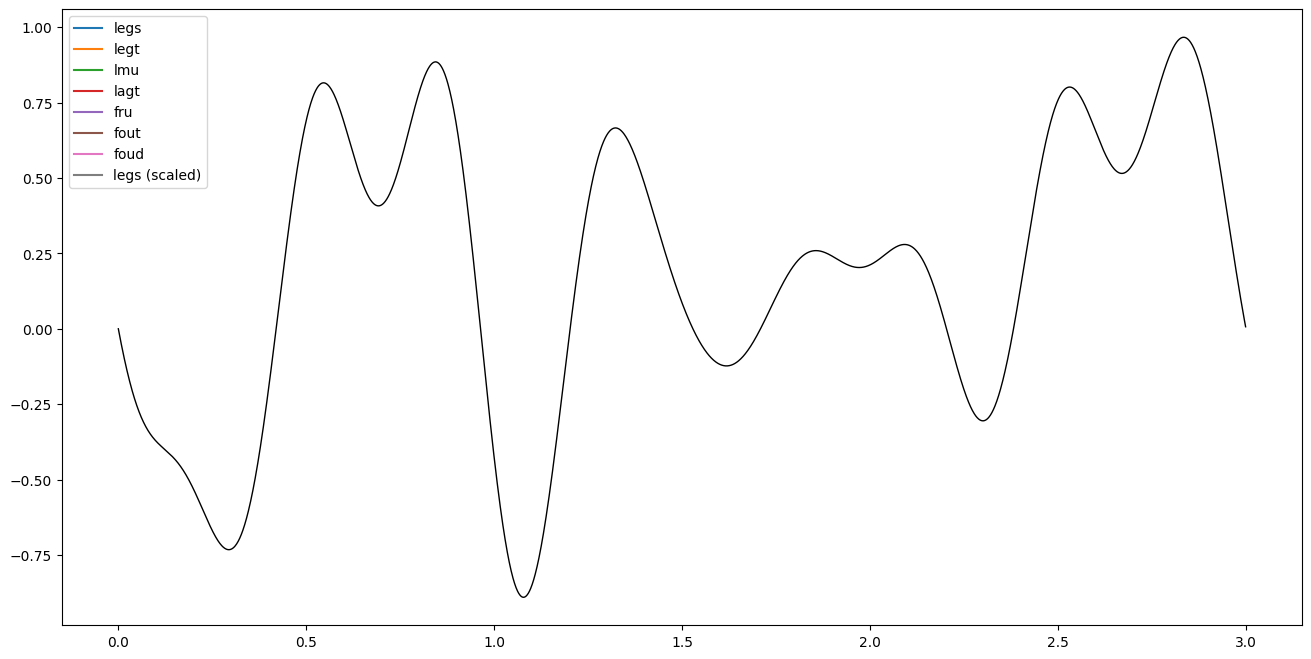

In [14]:
u, y_dict = plot(T=T, dt=dt, N=N, freq=freq, alpha=0.0)

LTI:
LSI:


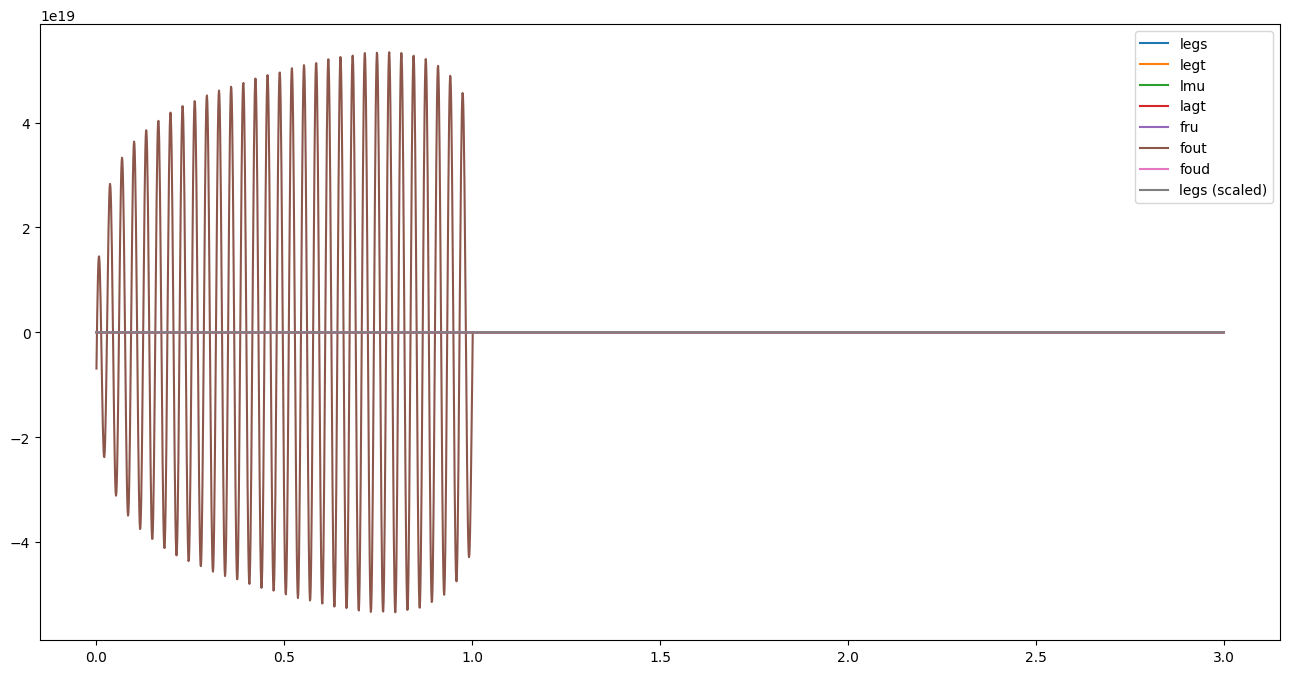

In [15]:
gu_u, gu_y_dict = gu_plot(T=T, dt=dt, N=N, freq=freq, alpha=0.0)

#### LegS

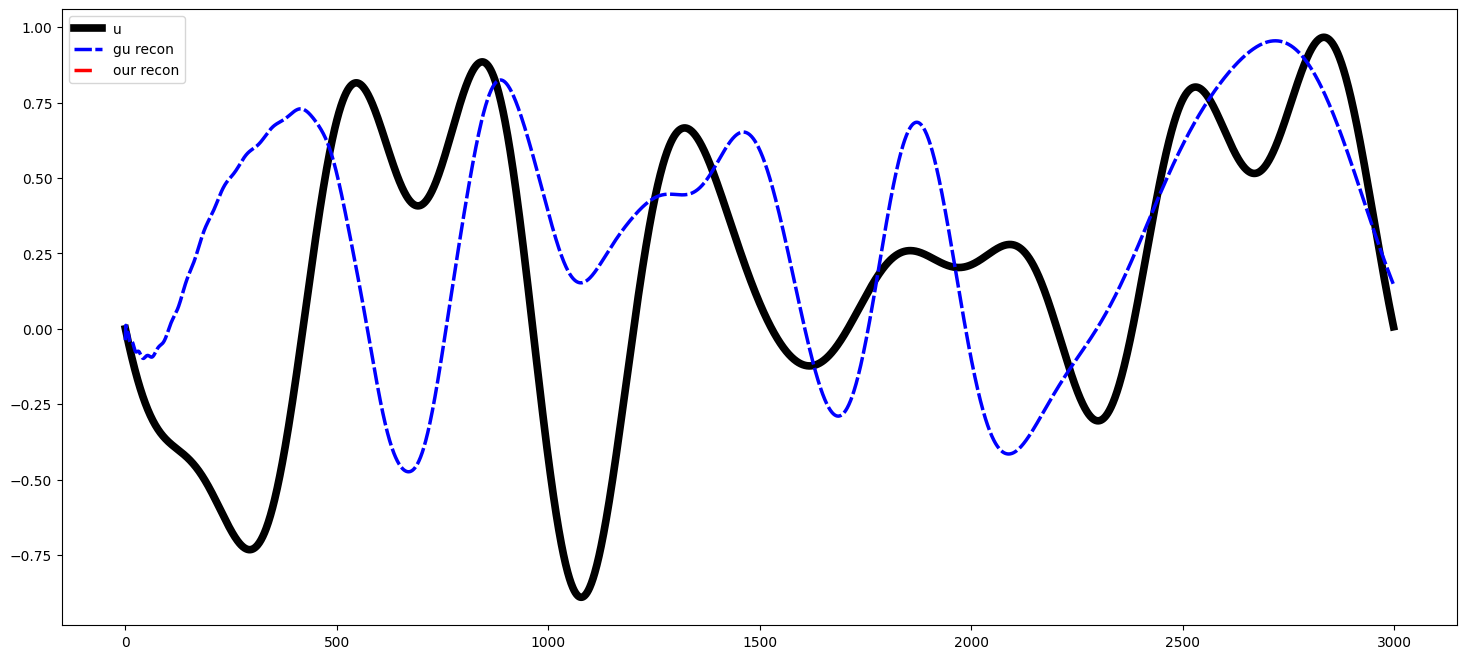

In [16]:
gu_y = gu_y_dict["legslti"]
y = y_dict["legslti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

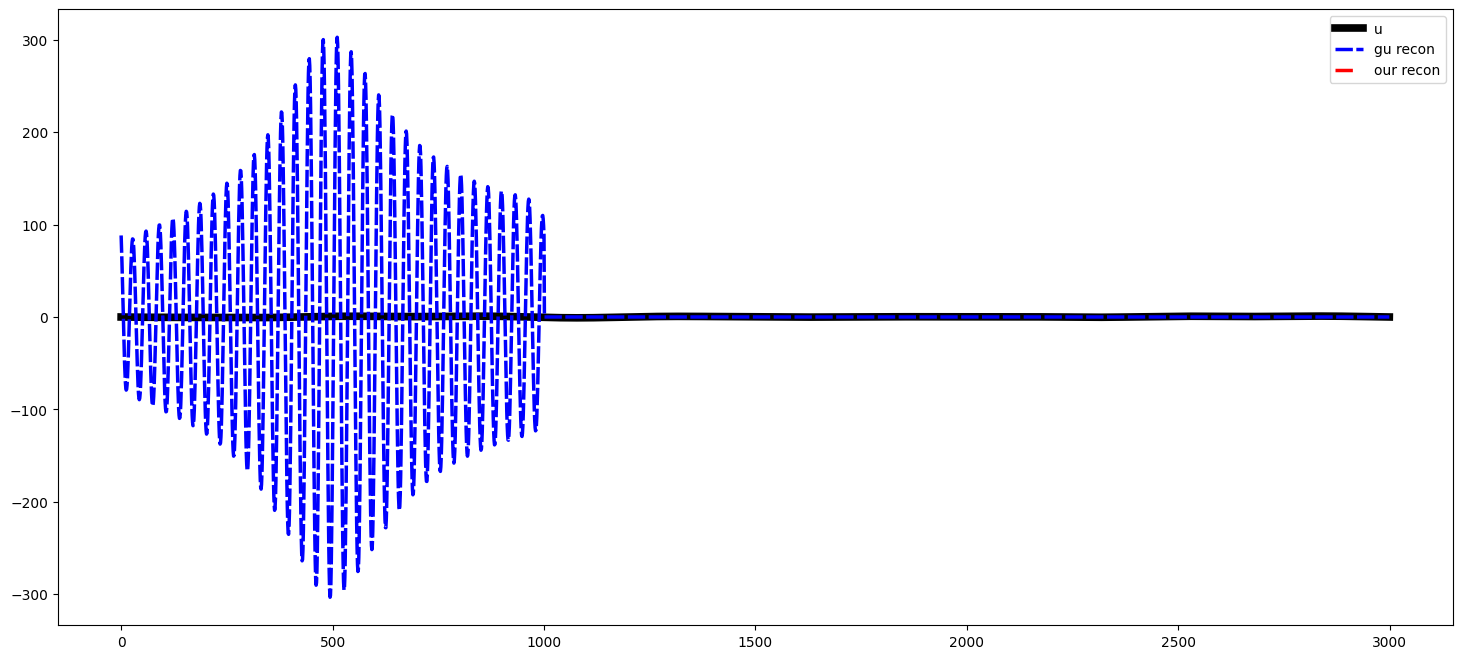

In [17]:
gu_y = gu_y_dict["legslsi"]
y = y_dict["legslsi"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### LegT

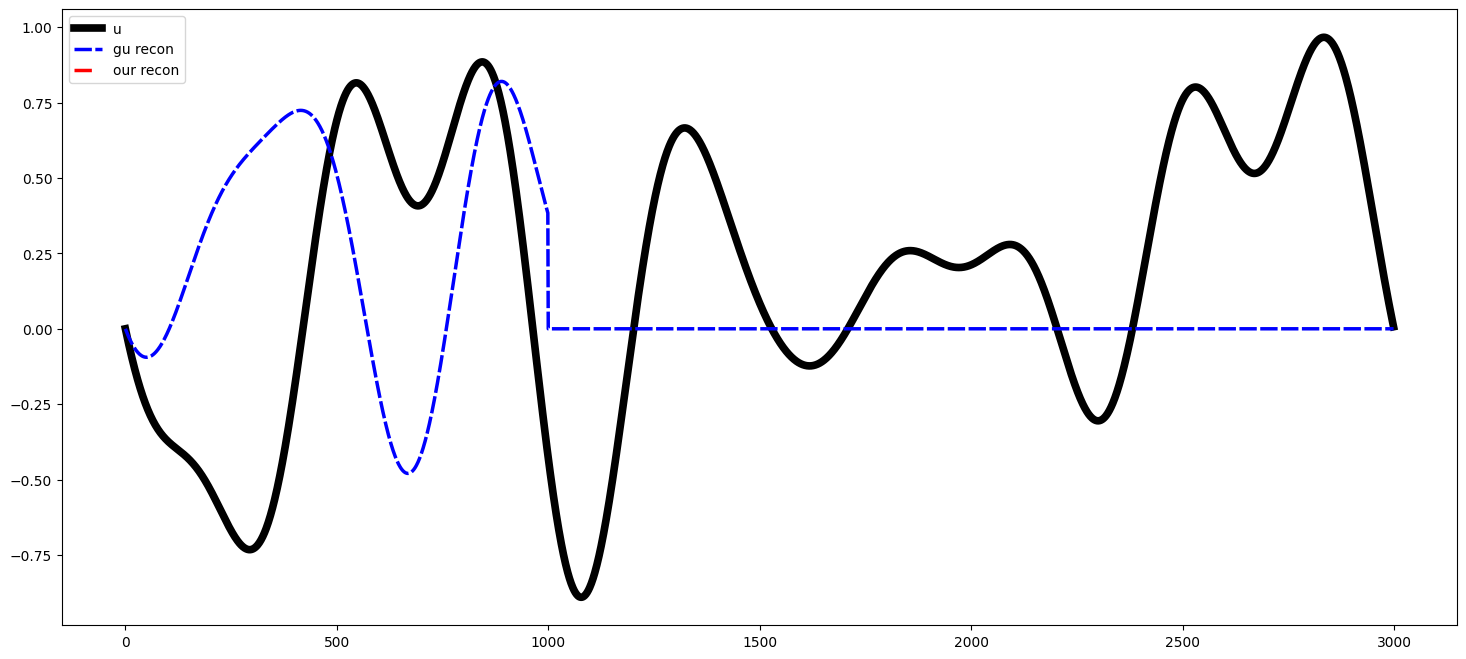

In [18]:
gu_y = gu_y_dict["legtlti"]
y = y_dict["legtlti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### LMU

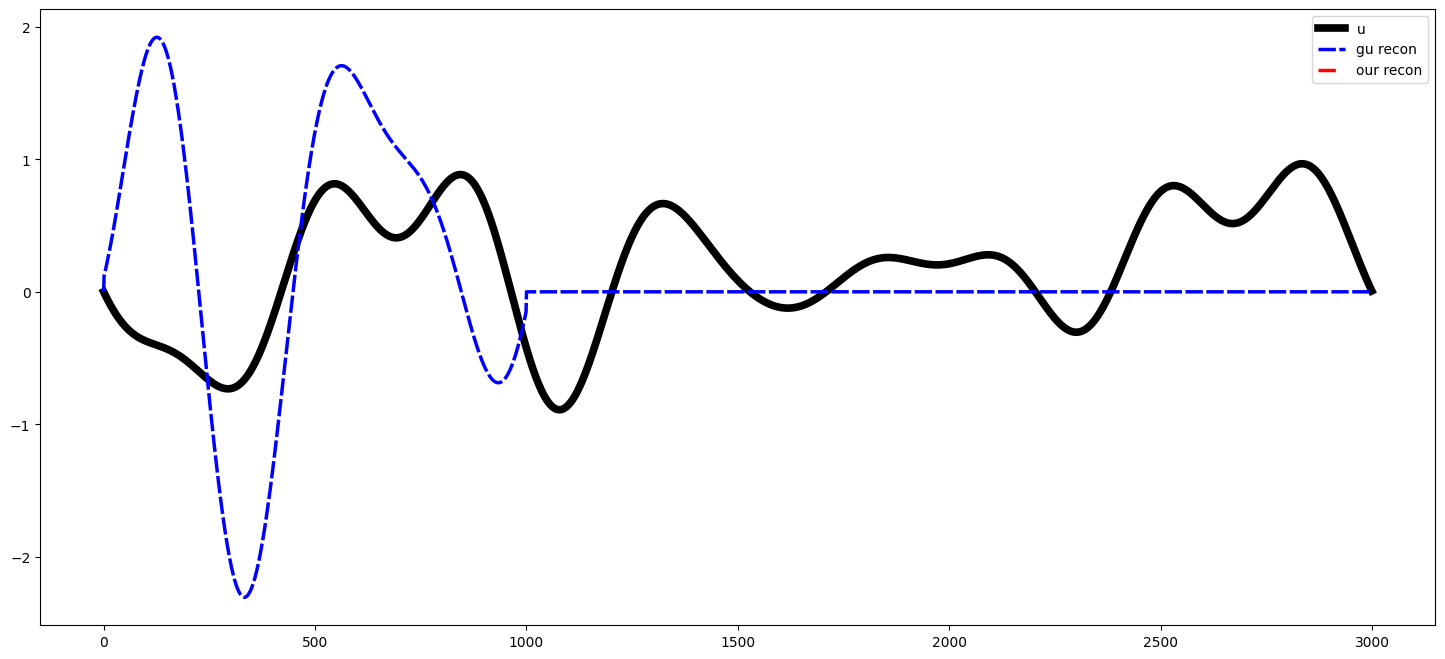

In [19]:
gu_y = gu_y_dict["lmulti"]
y = y_dict["lmulti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### LagT

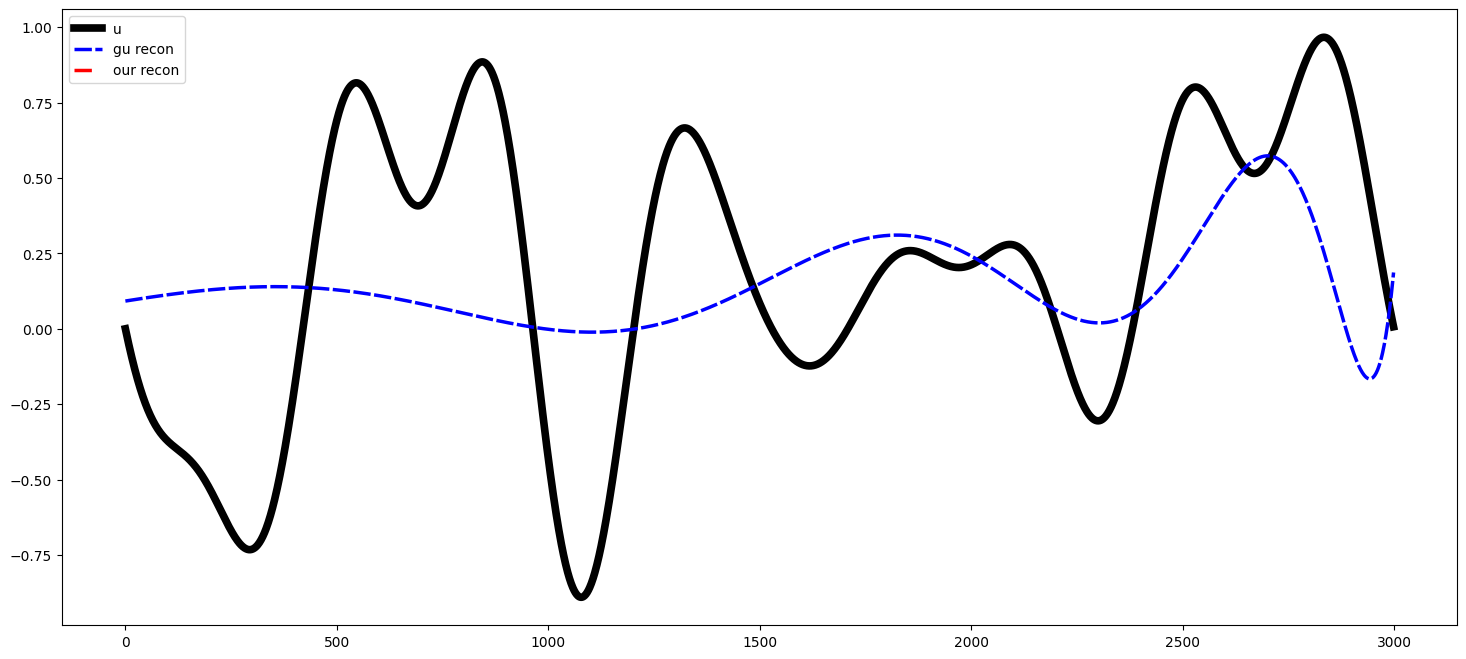

In [20]:
gu_y = gu_y_dict["lagtlti"]
y = y_dict["lagtlti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### FRU

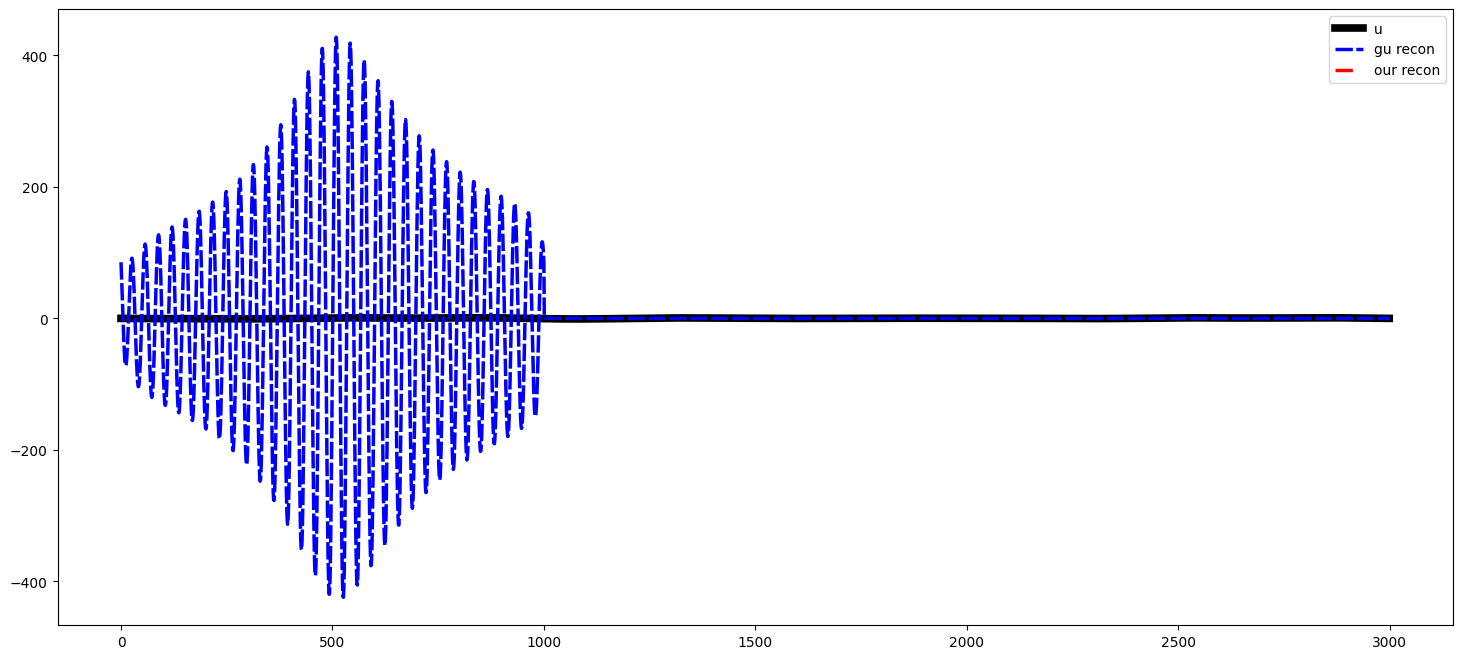

In [21]:
gu_y = gu_y_dict["frulti"]
y = y_dict["frulti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### FouT

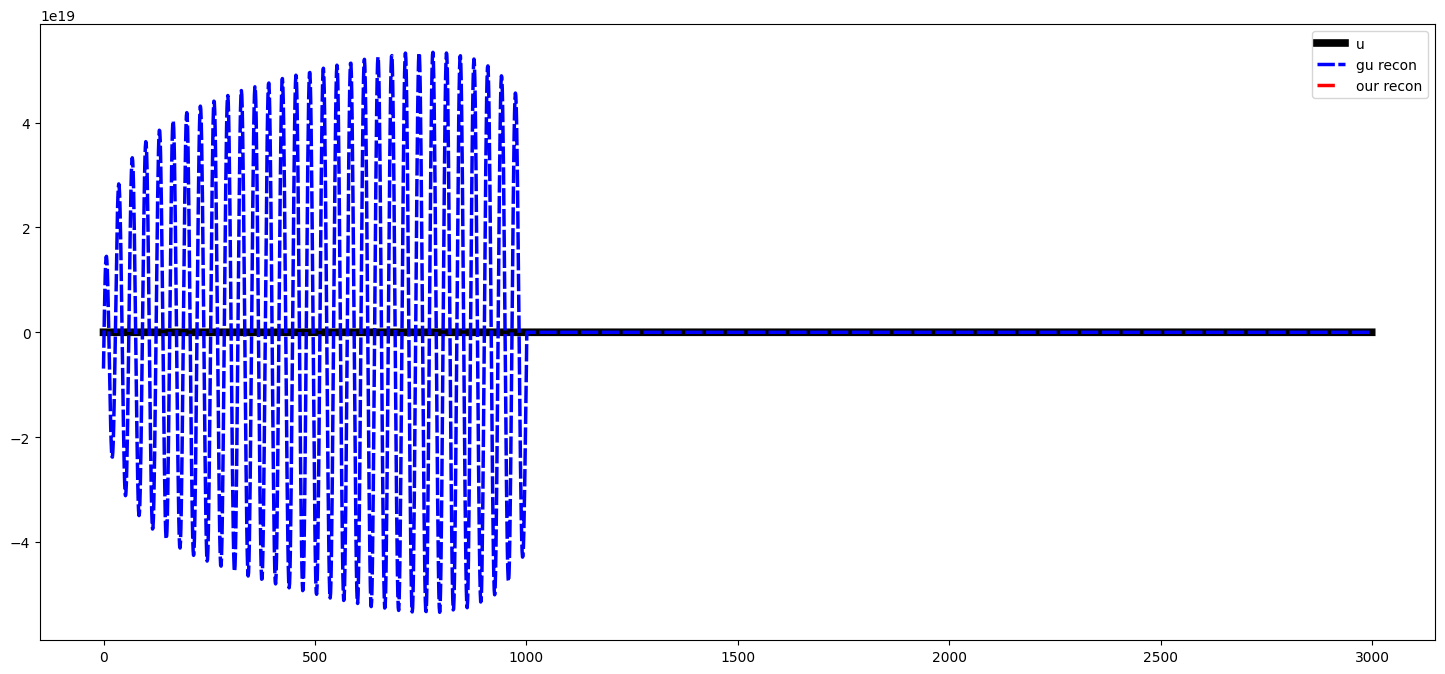

In [22]:
gu_y = gu_y_dict["foutlti"]
y = y_dict["foutlti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### FouD

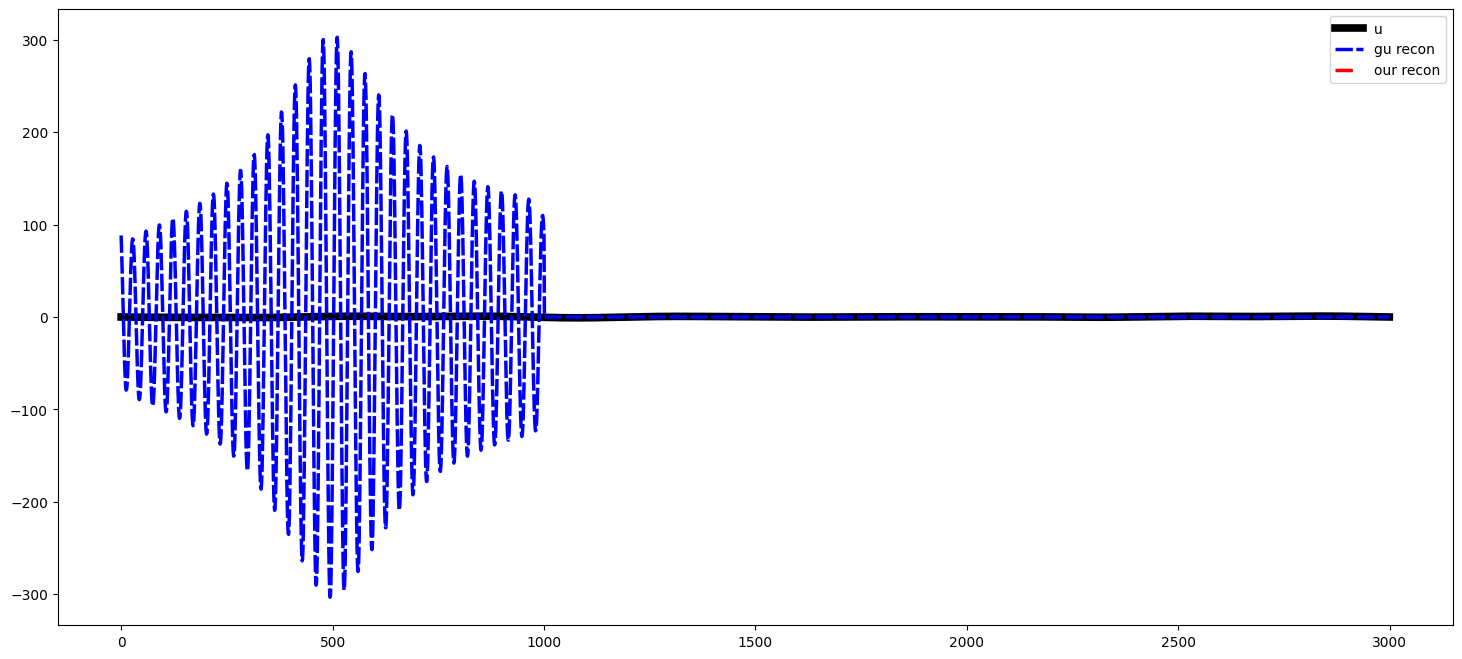

In [23]:
gu_y = gu_y_dict["foudlti"]
y = y_dict["foudlti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

### Testing (LTI and LSI) Operators With Backward Euler Transform

LTI:


/home/beegass/.cache/pypoetry/virtualenvs/s4mer-pkg-jZnBSgjq-py3.8/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4983: RuntimeWarning: overflow encountered in cast
  return binary_op(*args)


LSI:


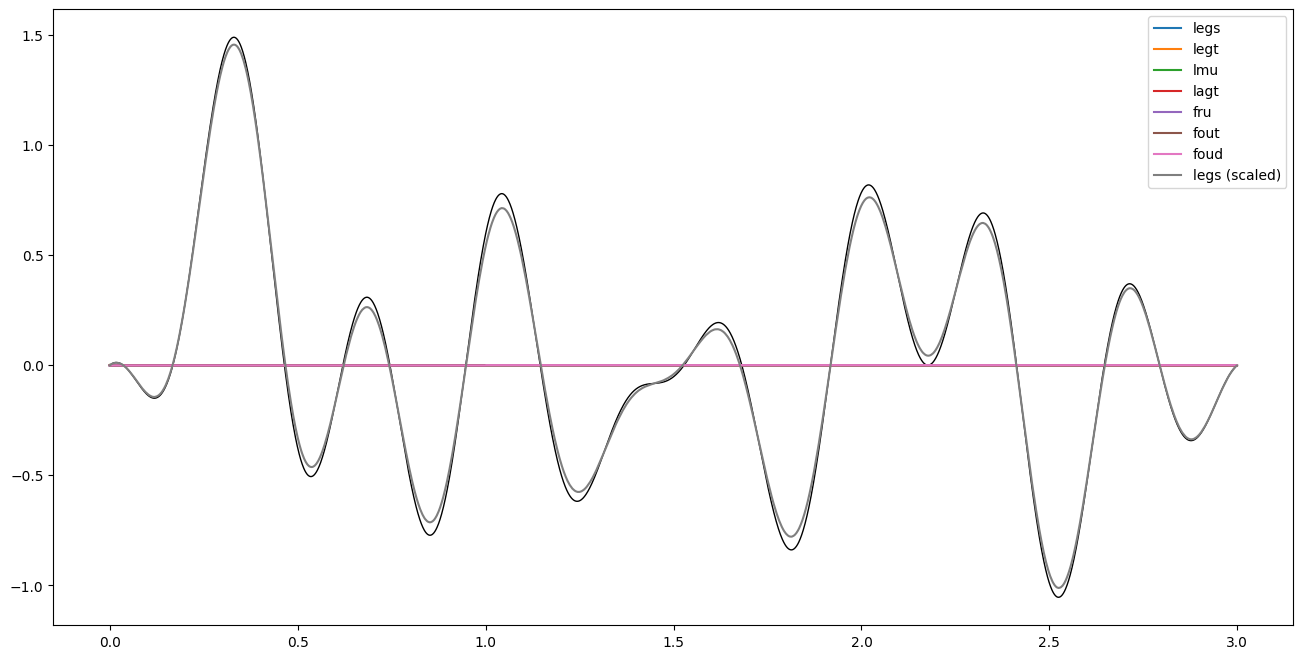

In [24]:
u, y_dict = plot(T=T, dt=dt, N=N, freq=freq, alpha=1.0)

LTI:
LSI:


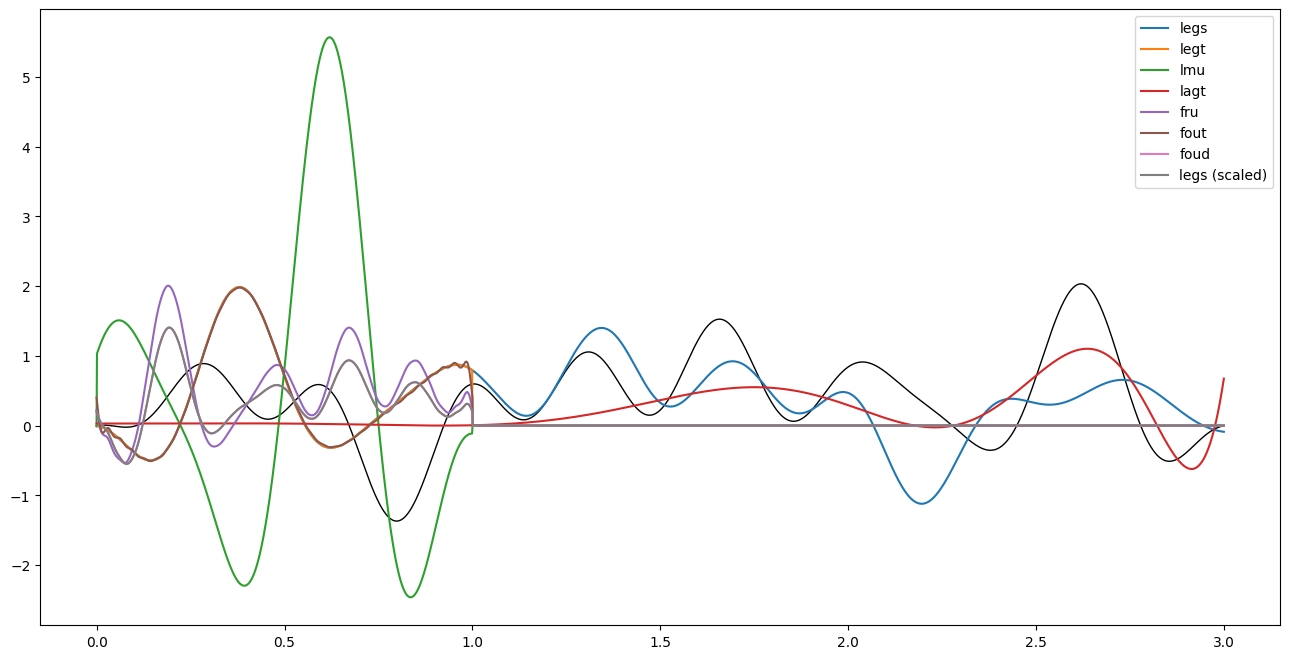

In [25]:
gu_u, gu_y_dict = gu_plot(T=T, dt=dt, N=N, freq=freq, alpha=1.0)

#### LegS

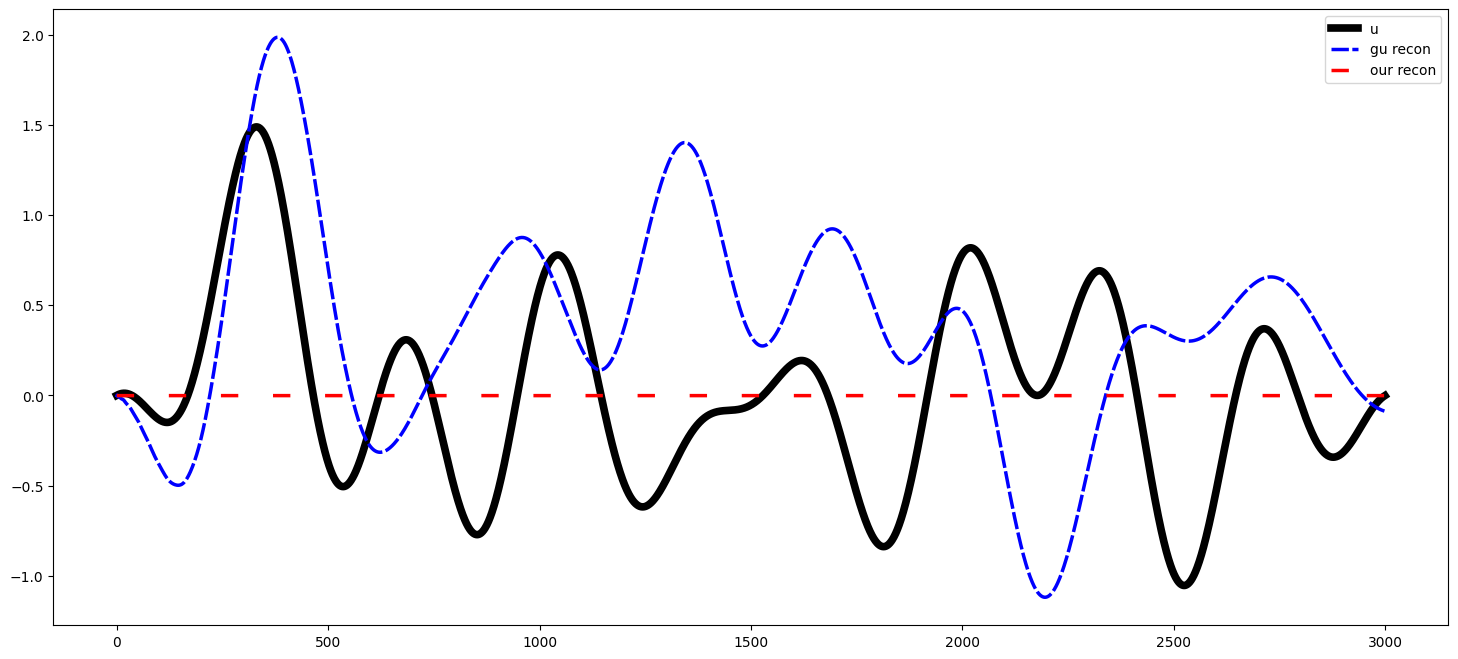

In [26]:
gu_y = gu_y_dict["legslti"]
y = y_dict["legslti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

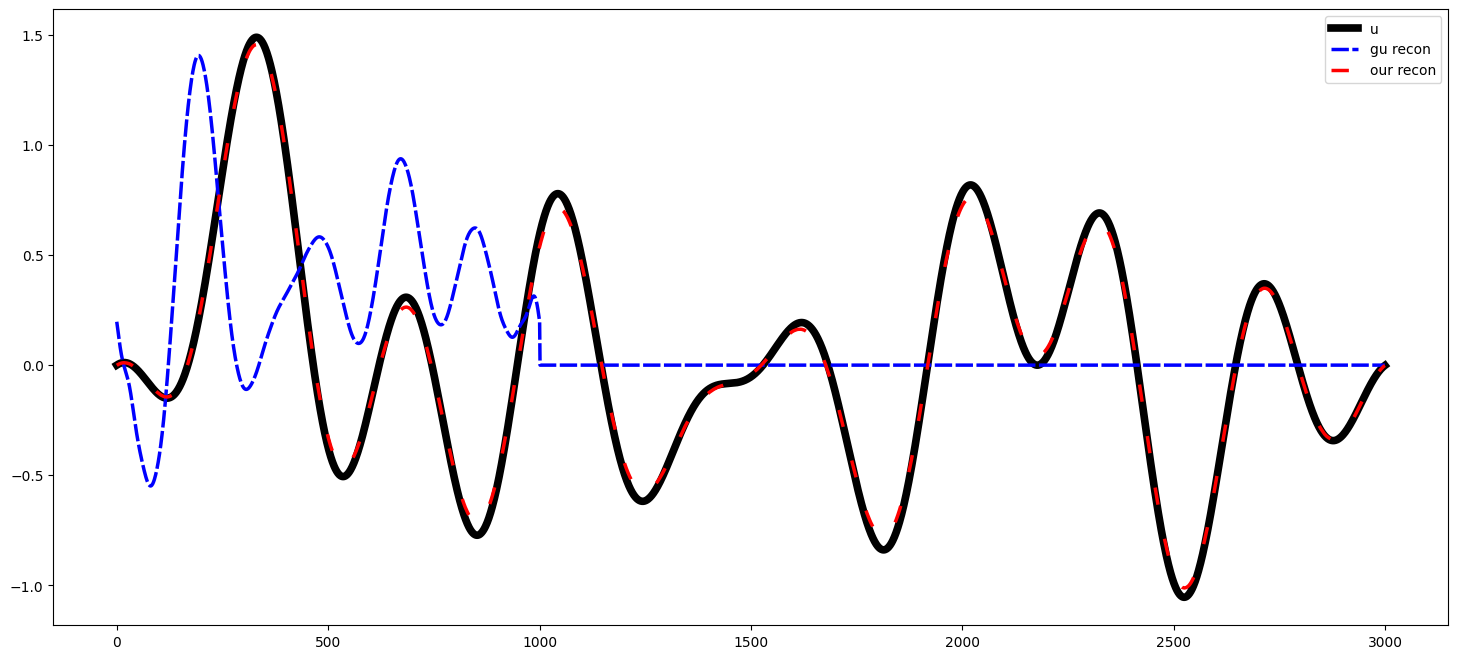

In [27]:
gu_y = gu_y_dict["legslsi"]
y = y_dict["legslsi"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### LegT

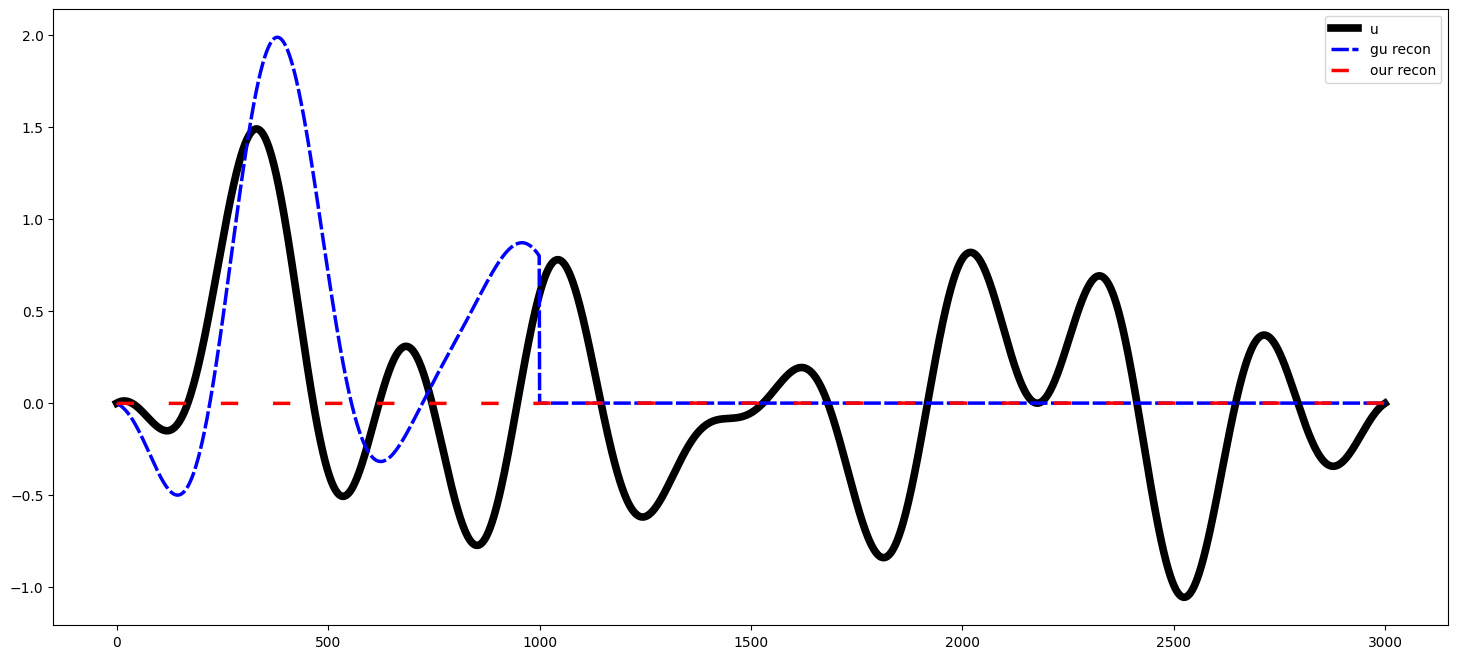

In [28]:
gu_y = gu_y_dict["legtlti"]
y = y_dict["legtlti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### LMU

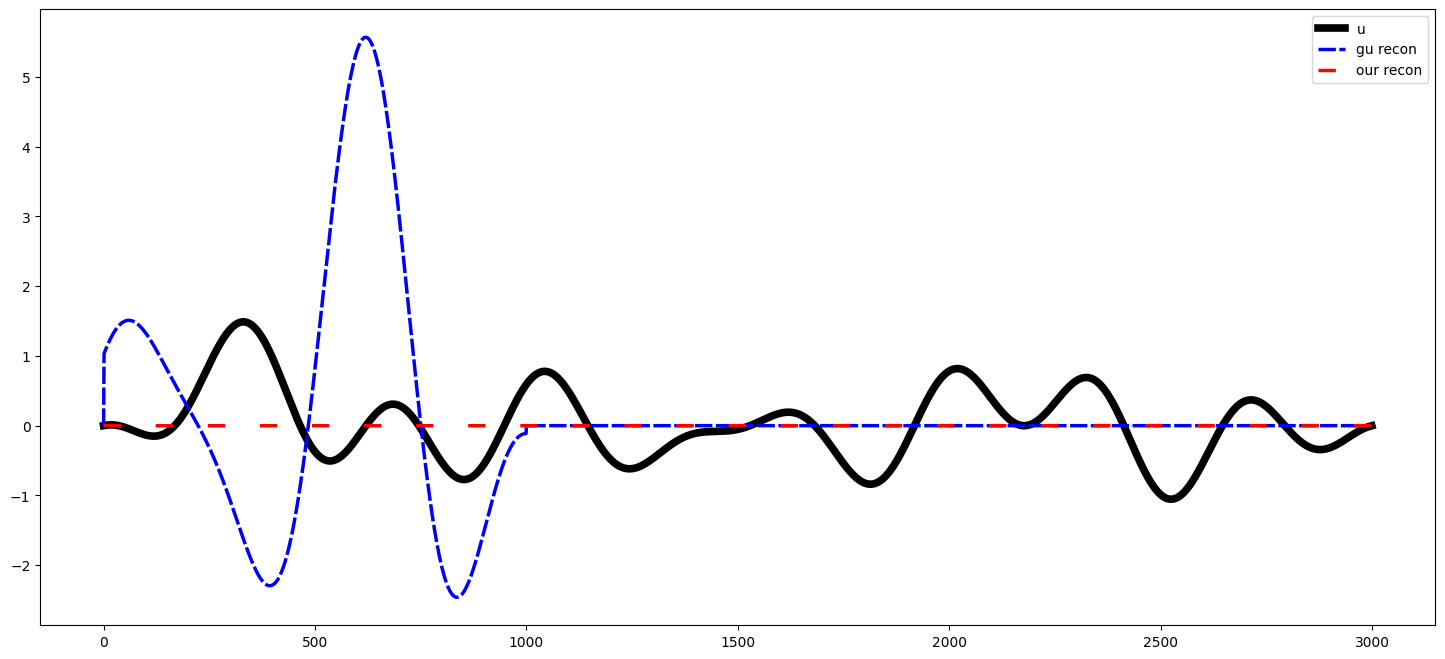

In [29]:
gu_y = gu_y_dict["lmulti"]
y = y_dict["lmulti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### LagT

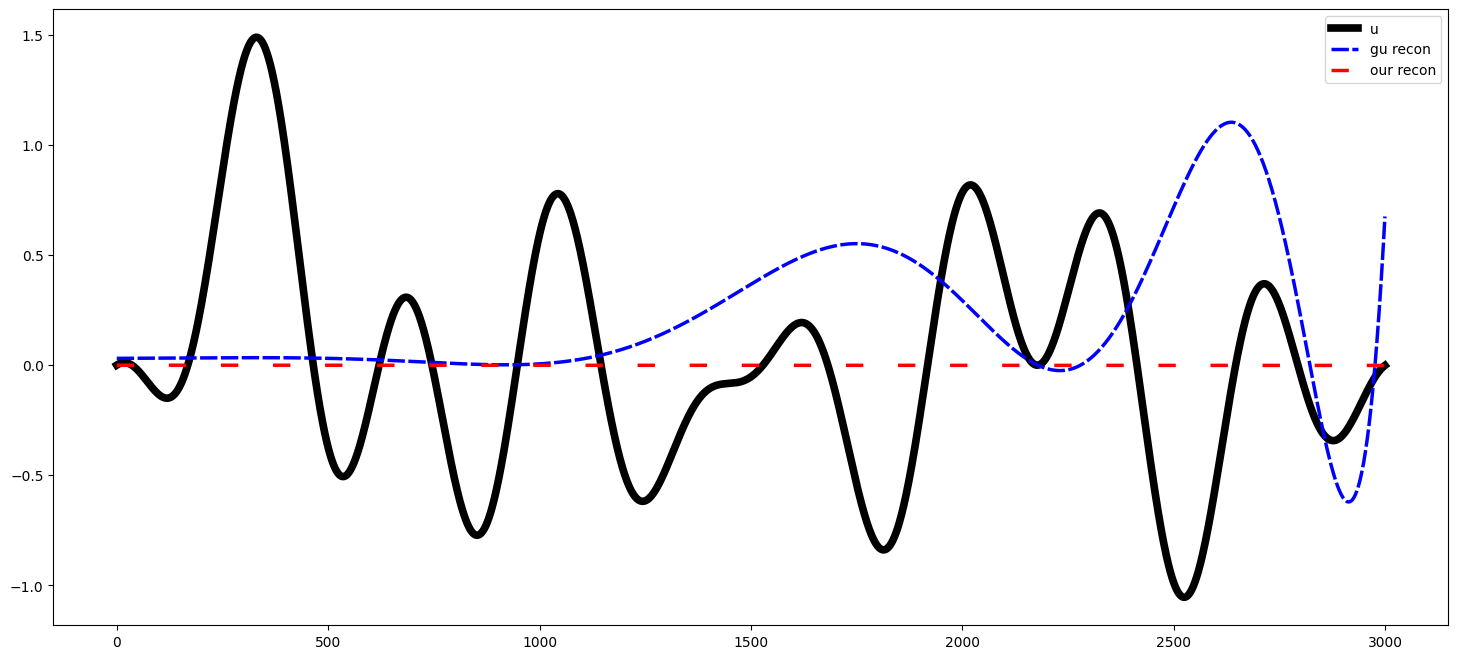

In [30]:
gu_y = gu_y_dict["lagtlti"]
y = y_dict["lagtlti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### FRU

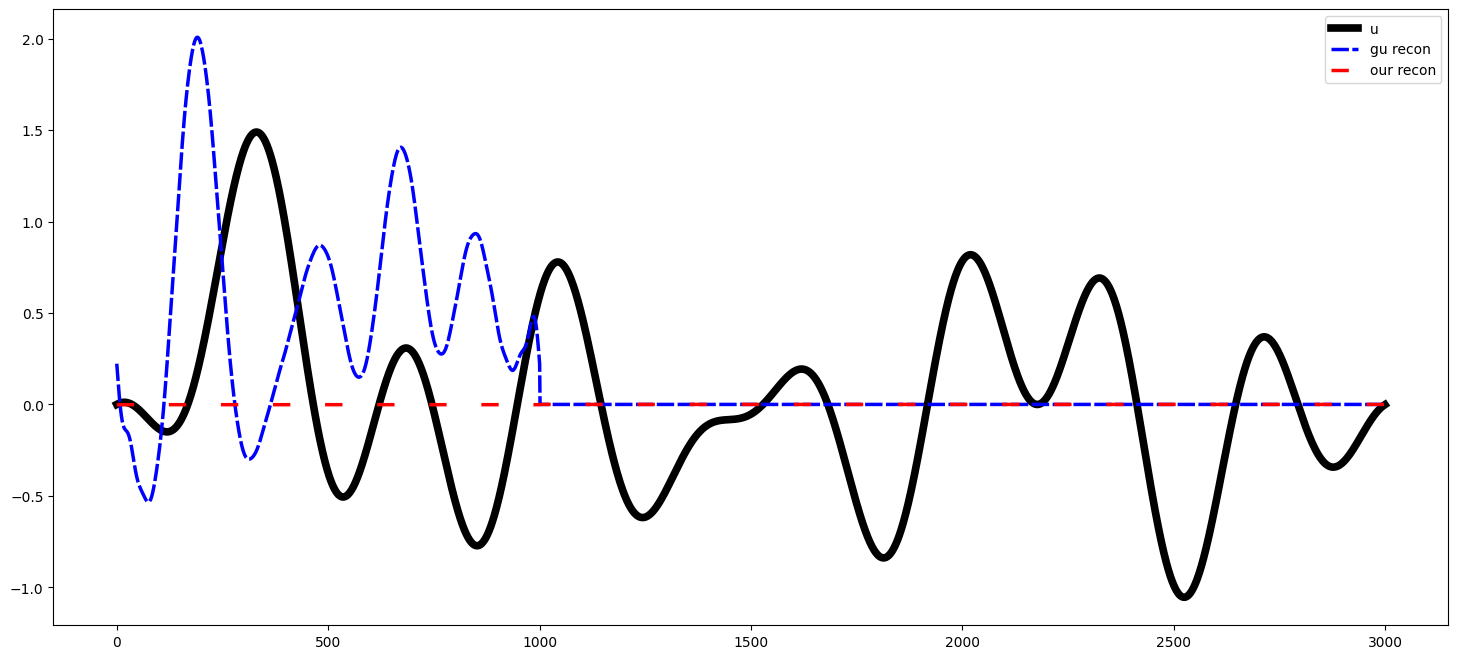

In [31]:
gu_y = gu_y_dict["frulti"]
y = y_dict["frulti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### FouT

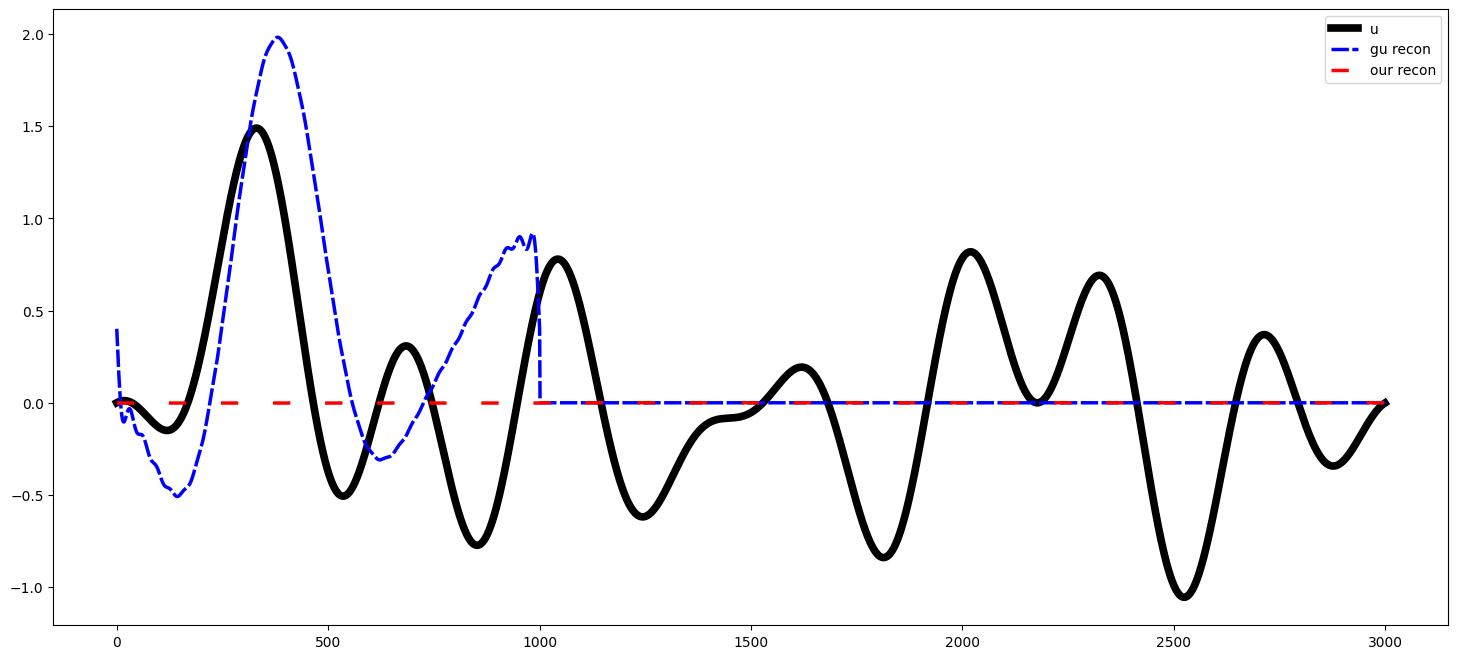

In [32]:
gu_y = gu_y_dict["foutlti"]
y = y_dict["foutlti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### FouD

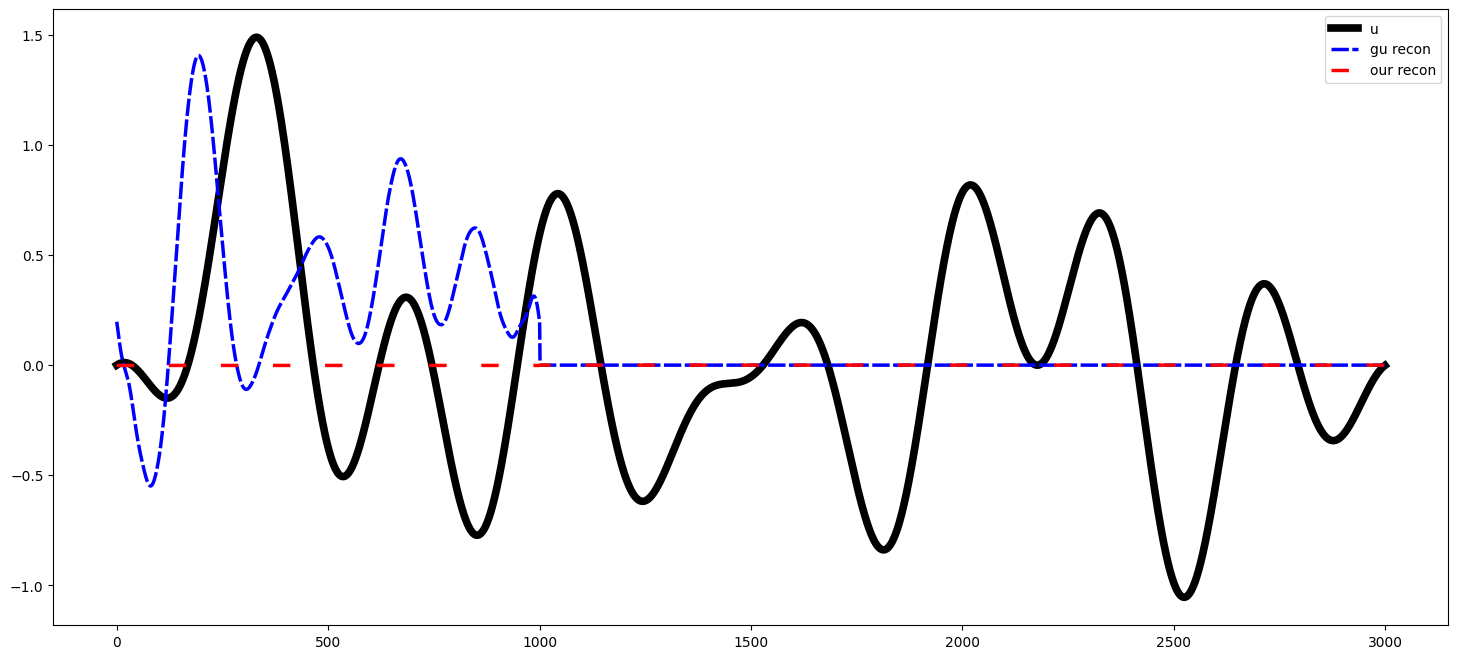

In [33]:
gu_y = gu_y_dict["foudlti"]
y = y_dict["foudlti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

### Testing (LTI and LSI) Operators With Bidirectional Transform

LTI:


/home/beegass/.cache/pypoetry/virtualenvs/s4mer-pkg-jZnBSgjq-py3.8/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4983: RuntimeWarning: overflow encountered in cast
  return binary_op(*args)


LSI:


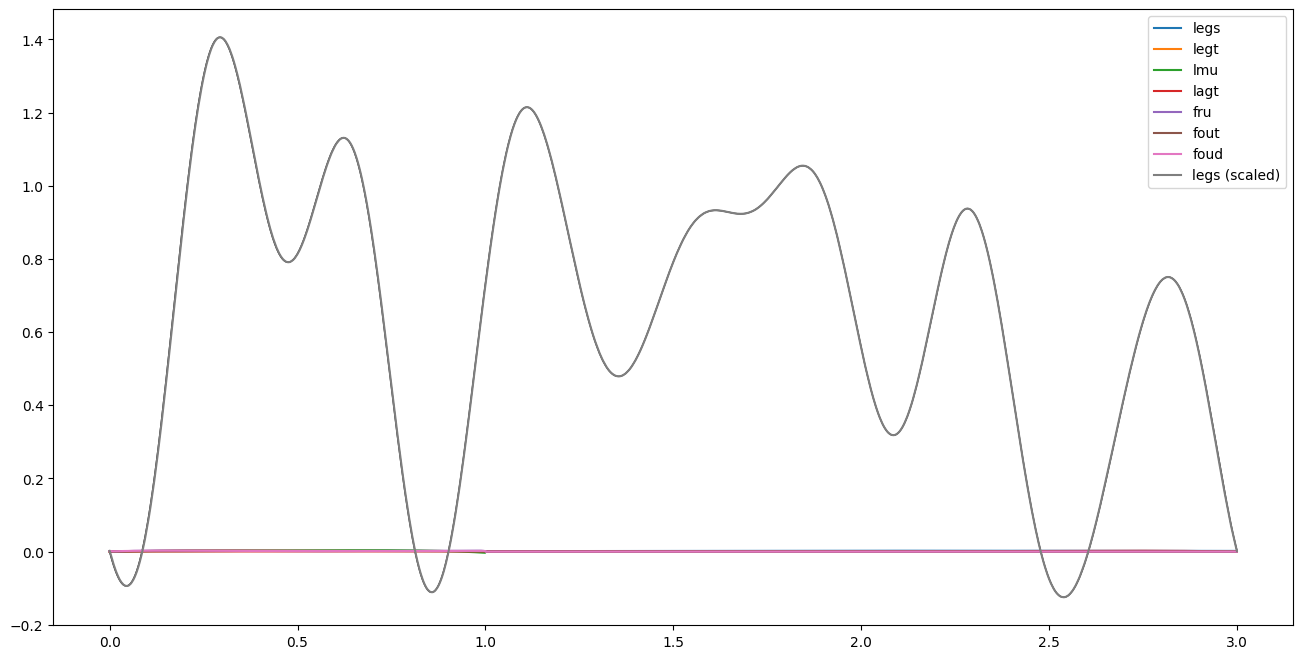

In [34]:
u, y_dict = plot(T=T, dt=dt, N=N, freq=freq, alpha=0.5)

LTI:
LSI:


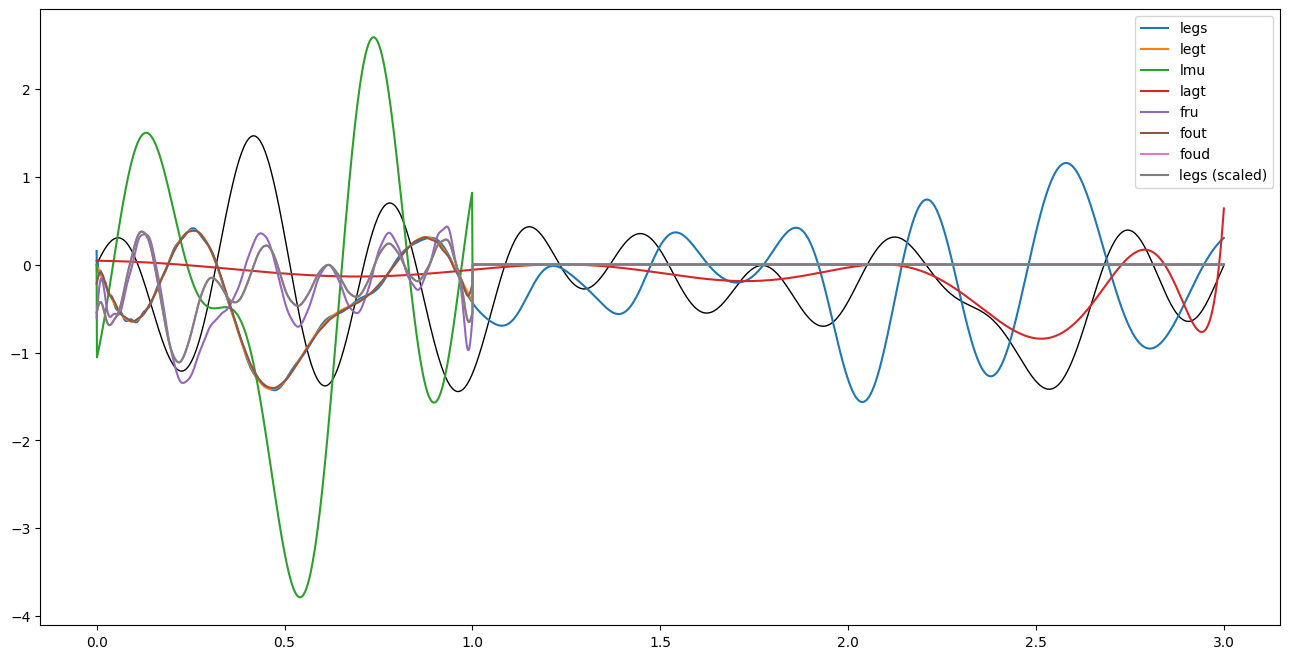

In [35]:
gu_u, gu_y_dict = gu_plot(T=T, dt=dt, N=N, freq=freq, alpha=0.5)

#### LegS

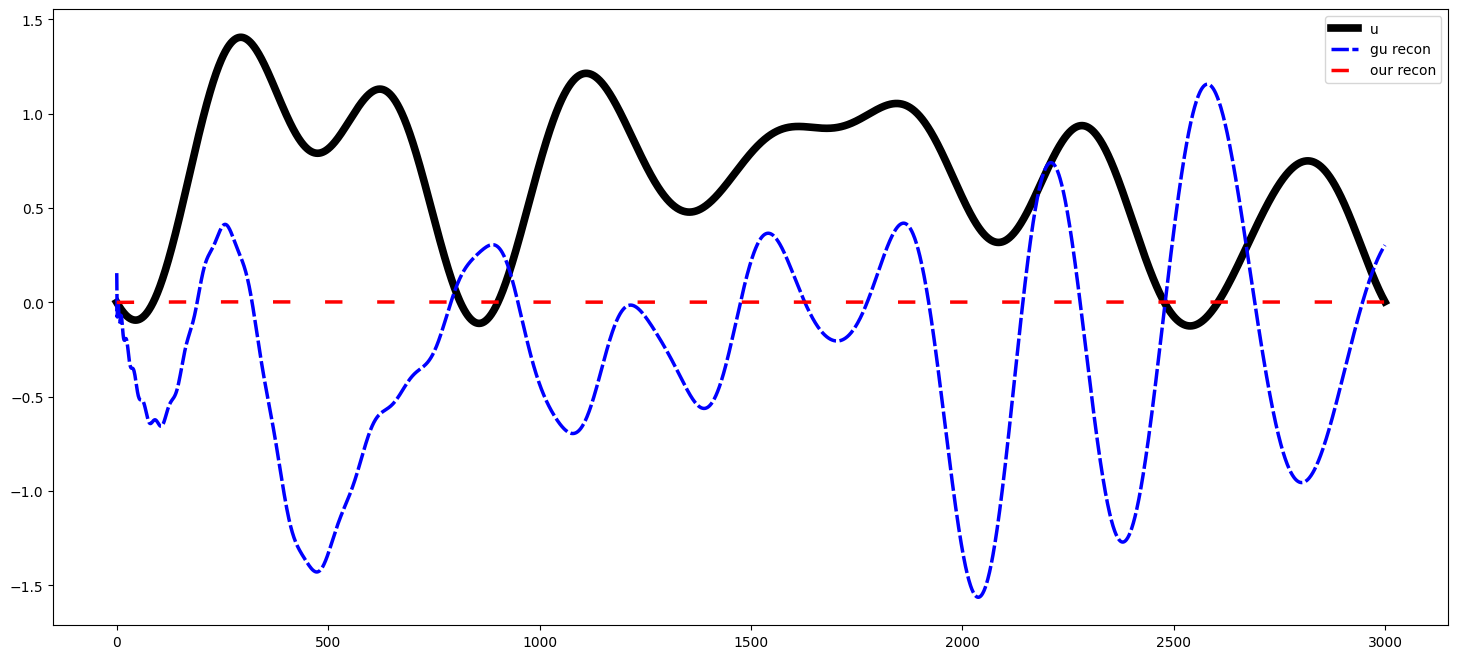

In [36]:
gu_y = gu_y_dict["legslti"]
y = y_dict["legslti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

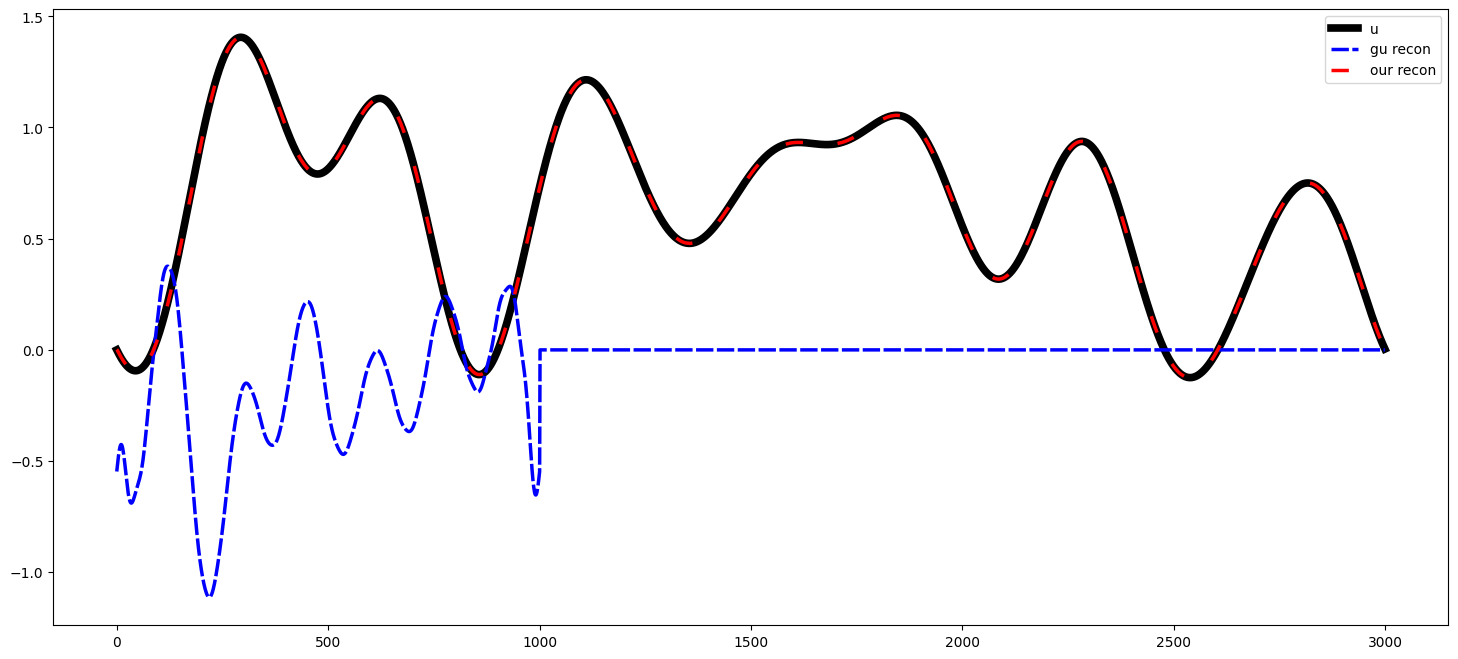

In [37]:
gu_y = gu_y_dict["legslsi"]
y = y_dict["legslsi"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### LegT

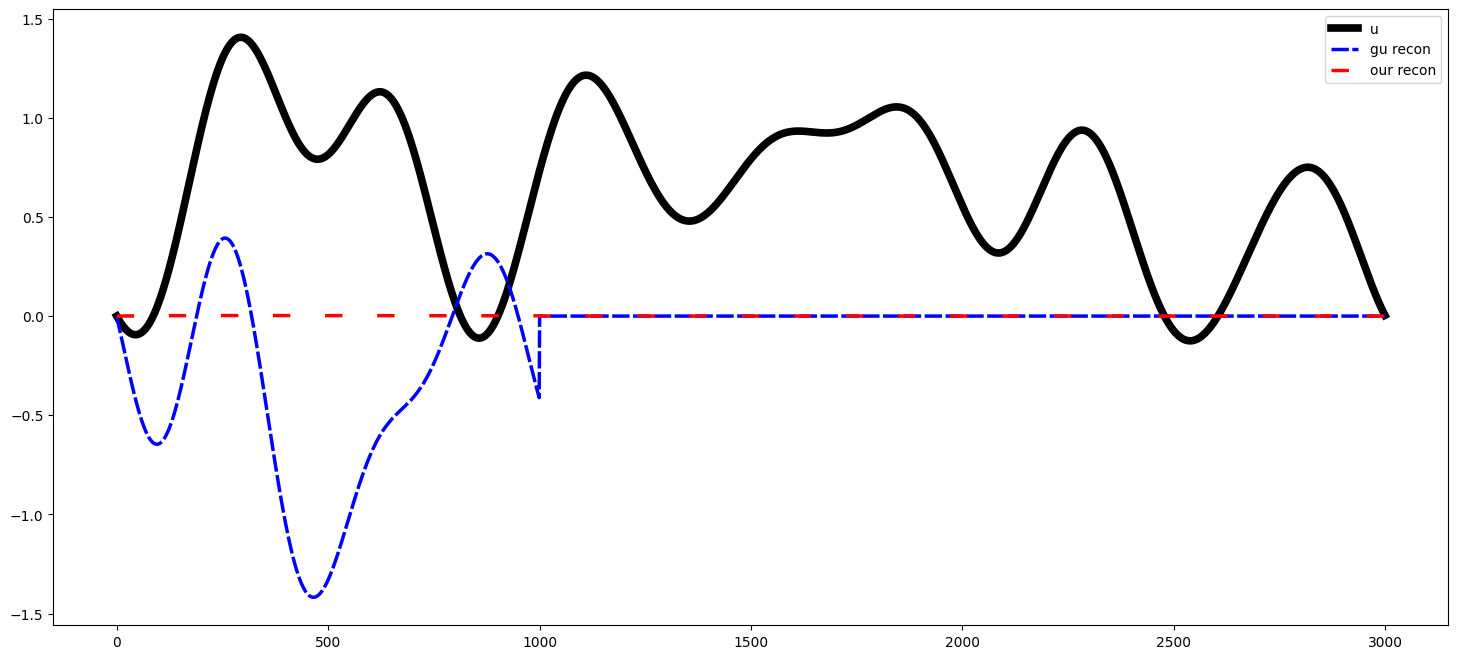

In [38]:
gu_y = gu_y_dict["legtlti"]
y = y_dict["legtlti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### LMU

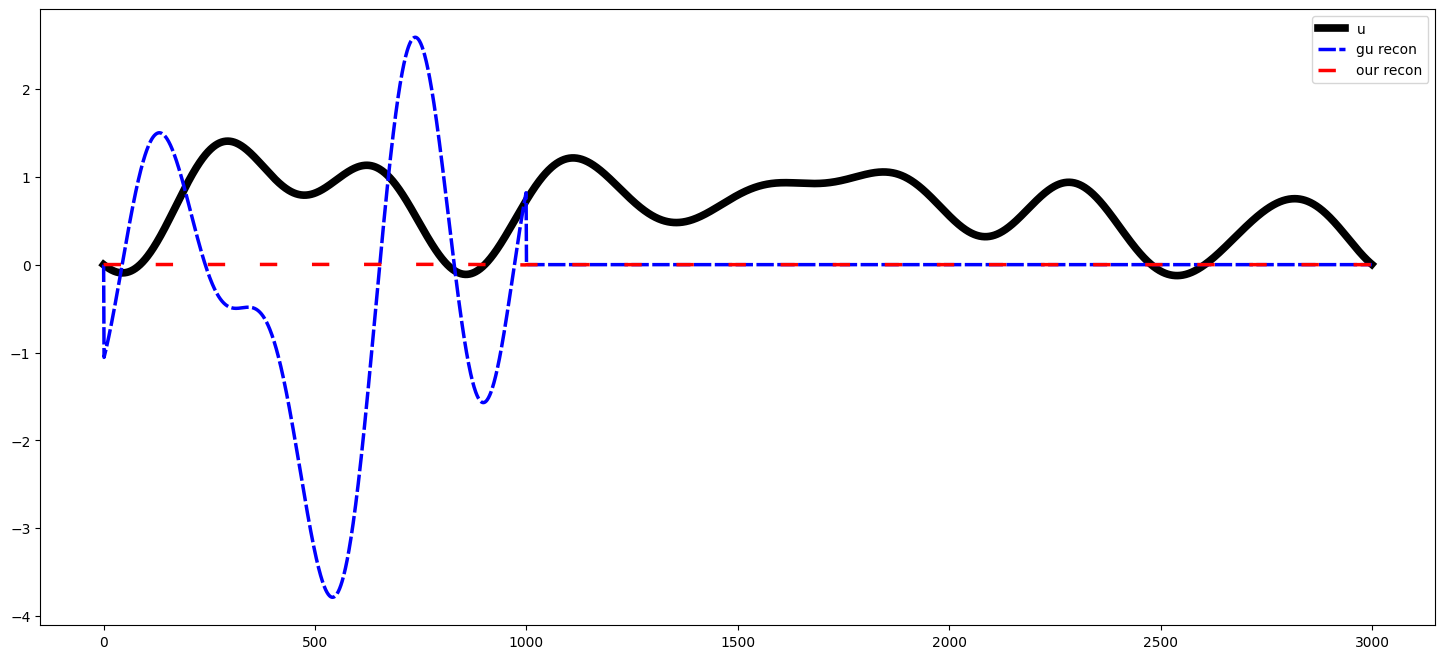

In [39]:
gu_y = gu_y_dict["lmulti"]
y = y_dict["lmulti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### LagT

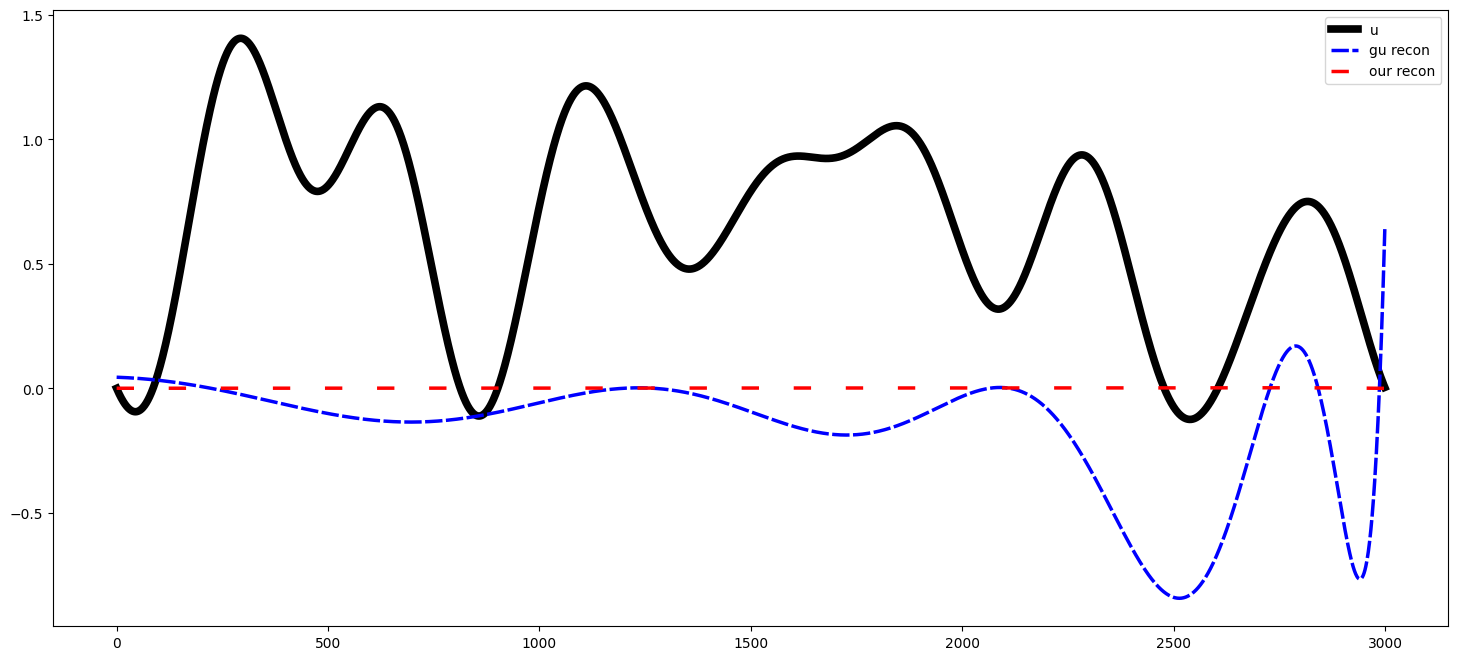

In [40]:
gu_y = gu_y_dict["lagtlti"]
y = y_dict["lagtlti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### FRU

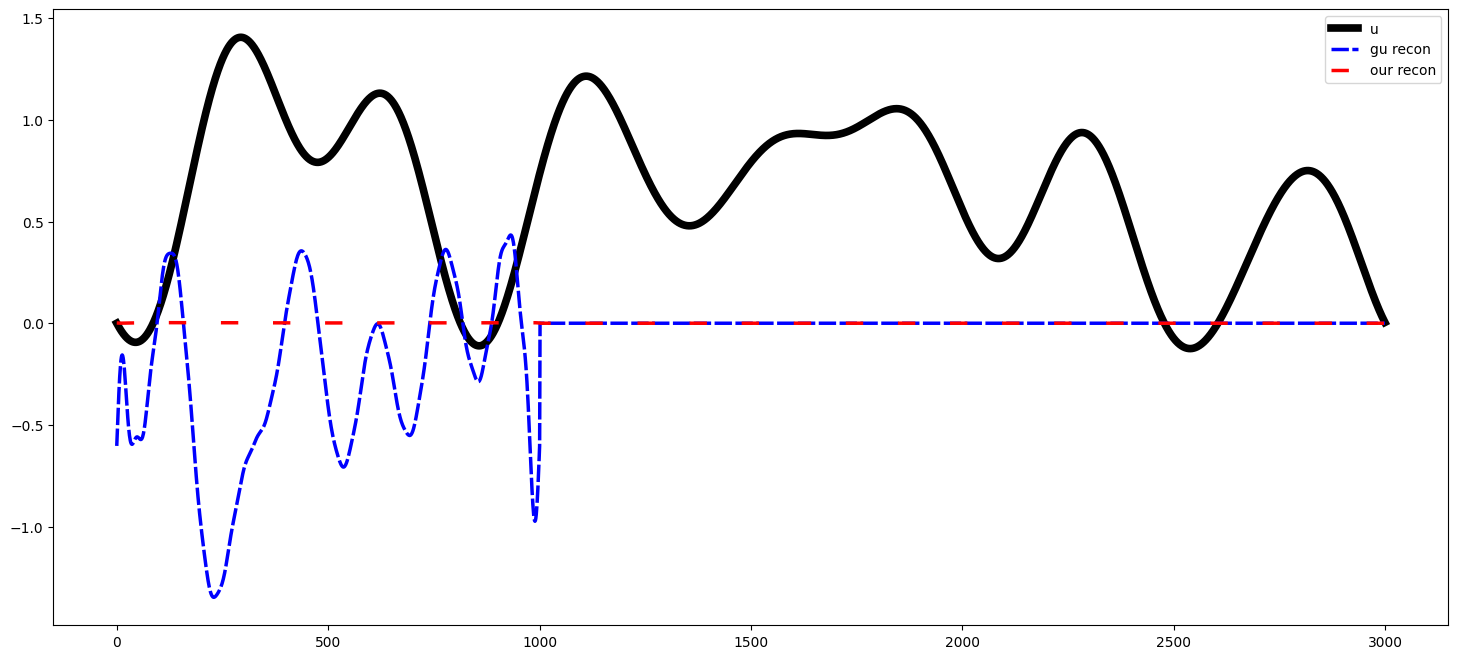

In [41]:
gu_y = gu_y_dict["frulti"]
y = y_dict["frulti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### FouT

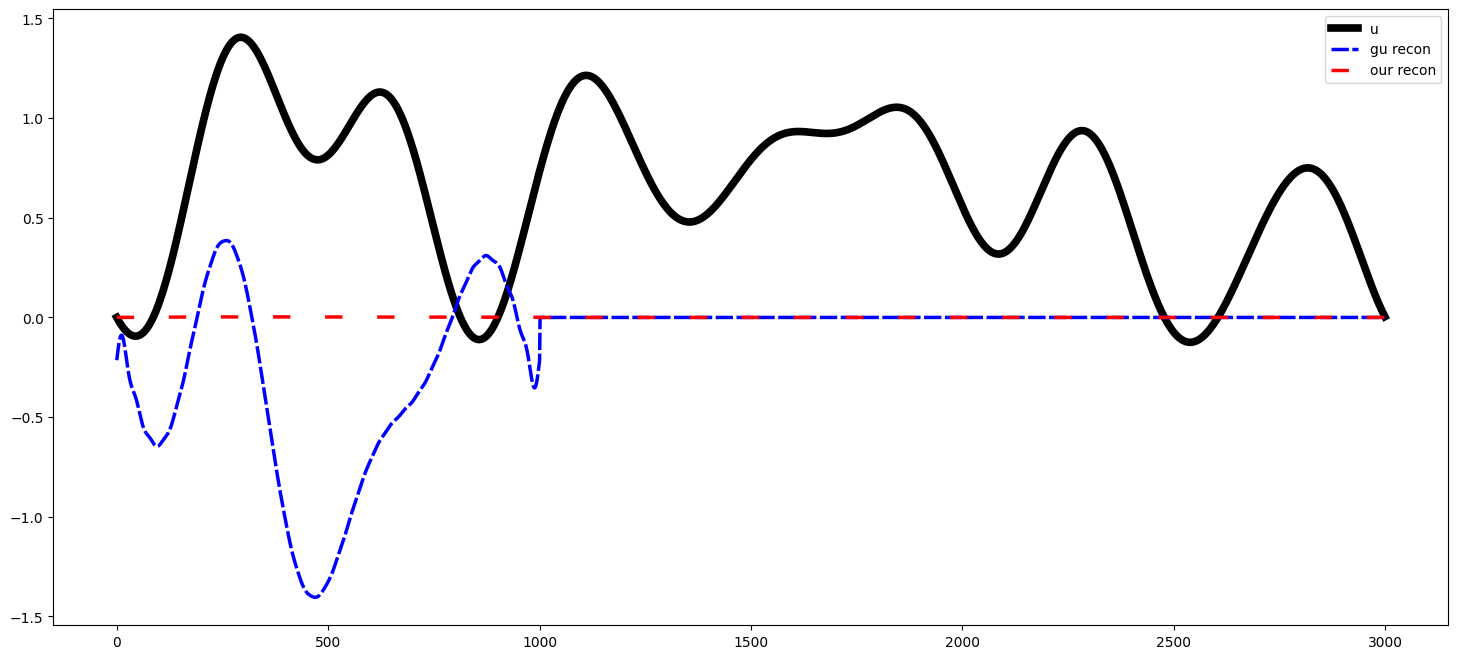

In [42]:
gu_y = gu_y_dict["foutlti"]
y = y_dict["foutlti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### FouD

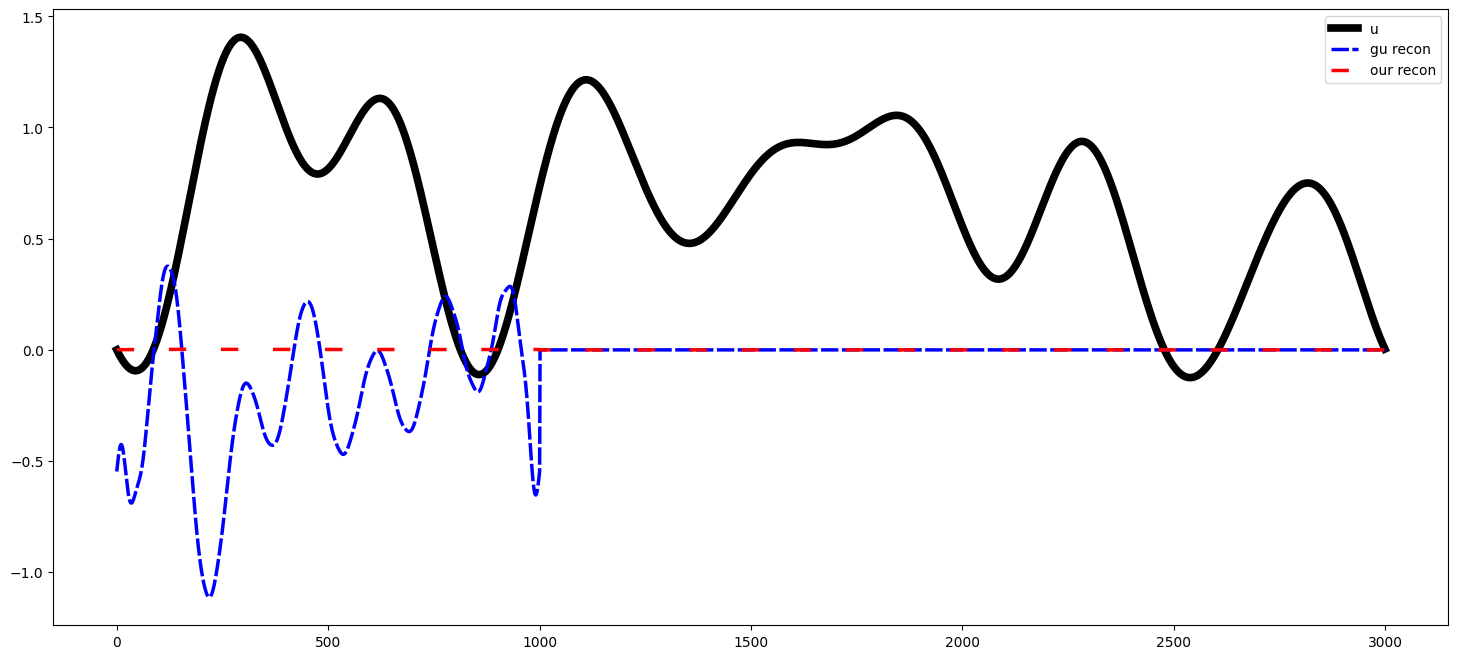

In [43]:
gu_y = gu_y_dict["foudlti"]
y = y_dict["foudlti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

### Testing (LTI and LSI) Operators With ZOH Transform

LTI:


/home/beegass/.cache/pypoetry/virtualenvs/s4mer-pkg-jZnBSgjq-py3.8/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4983: RuntimeWarning: overflow encountered in cast
  return binary_op(*args)


LSI:


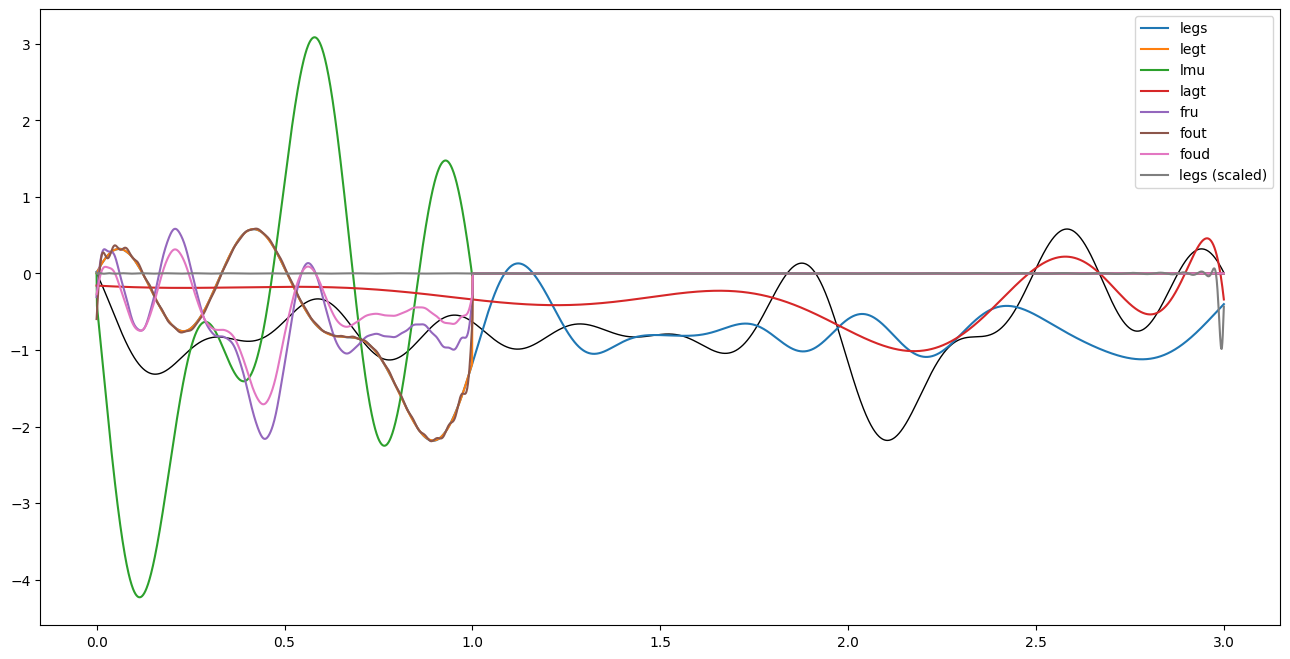

In [44]:
u, y_dict = plot(T=T, dt=dt, N=N, freq=freq, alpha=2.0)

LTI:
LSI:


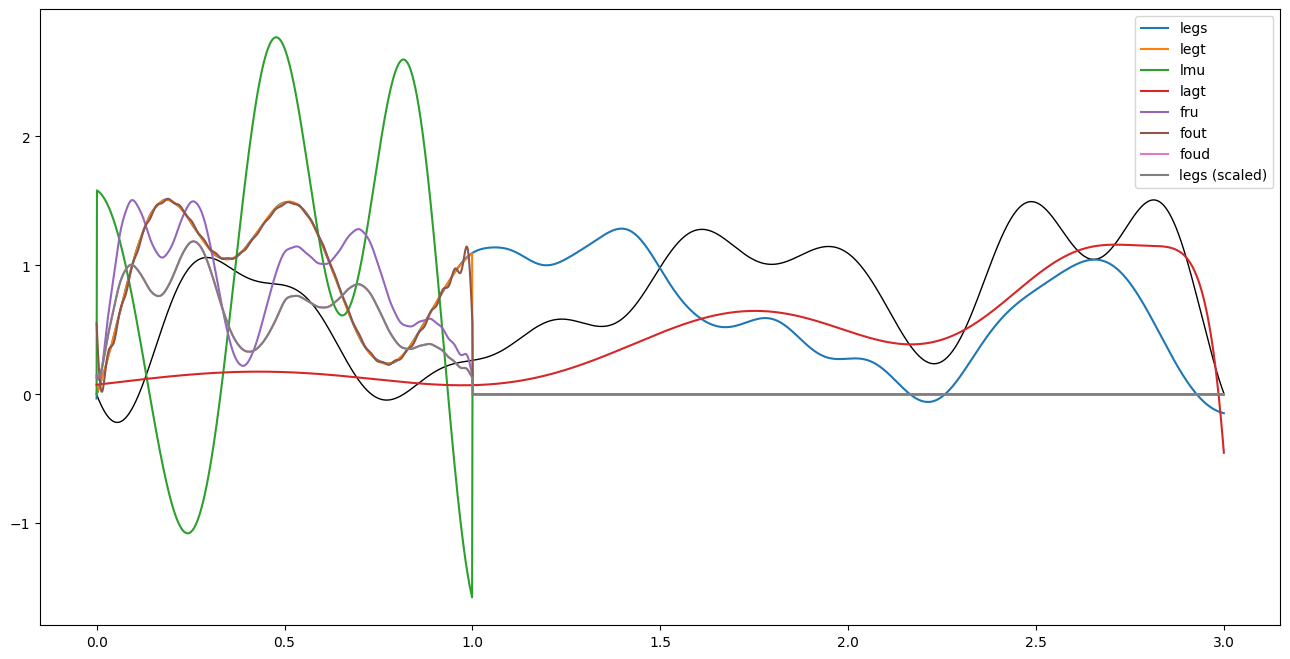

In [45]:
gu_u, gu_y_dict = gu_plot(T=T, dt=dt, N=N, freq=freq, alpha="zoh")

#### LegS

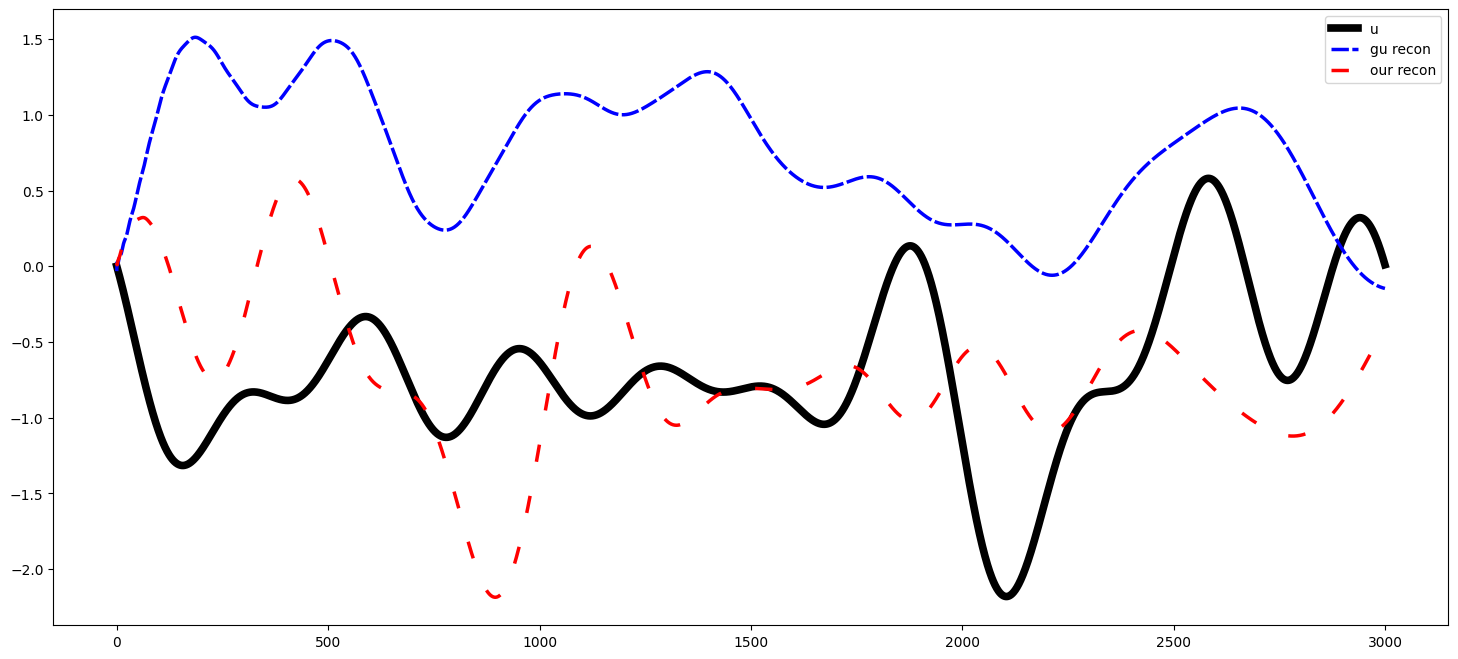

In [46]:
gu_y = gu_y_dict["legslti"]
y = y_dict["legslti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

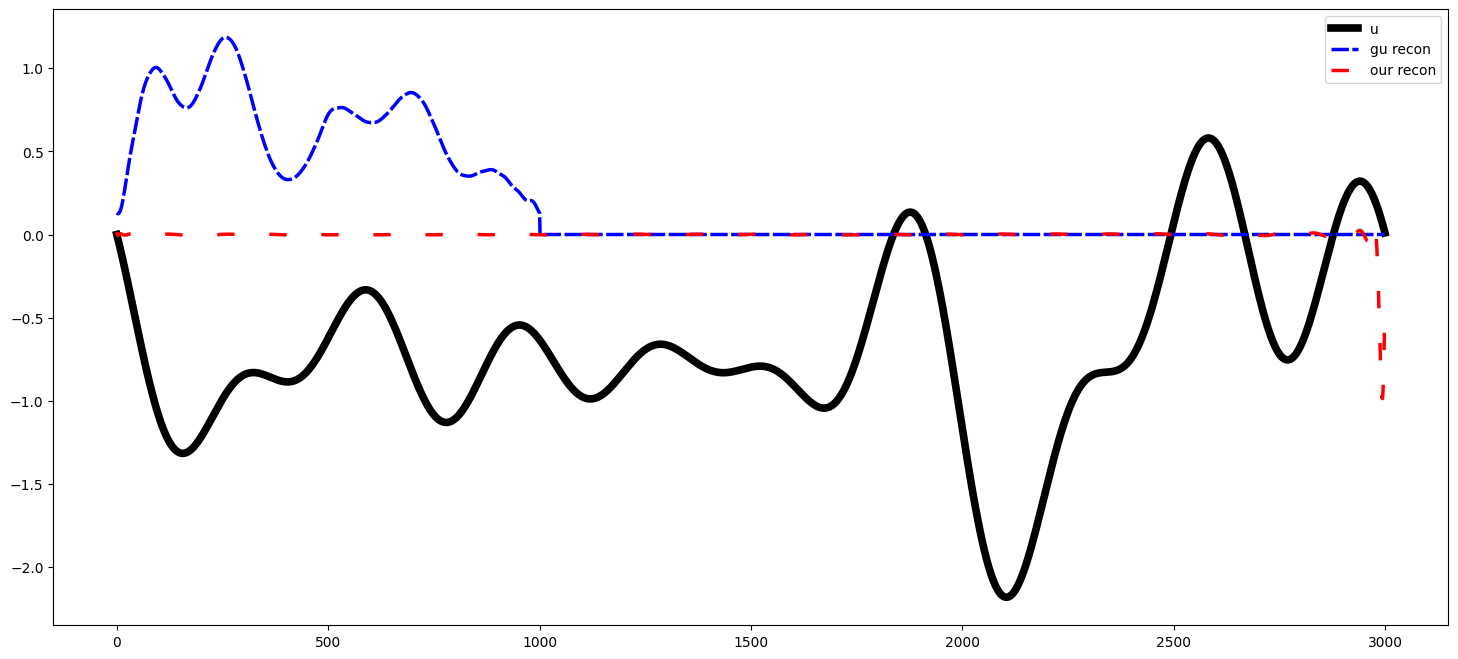

In [47]:
gu_y = gu_y_dict["legslsi"]
y = y_dict["legslsi"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### LegT

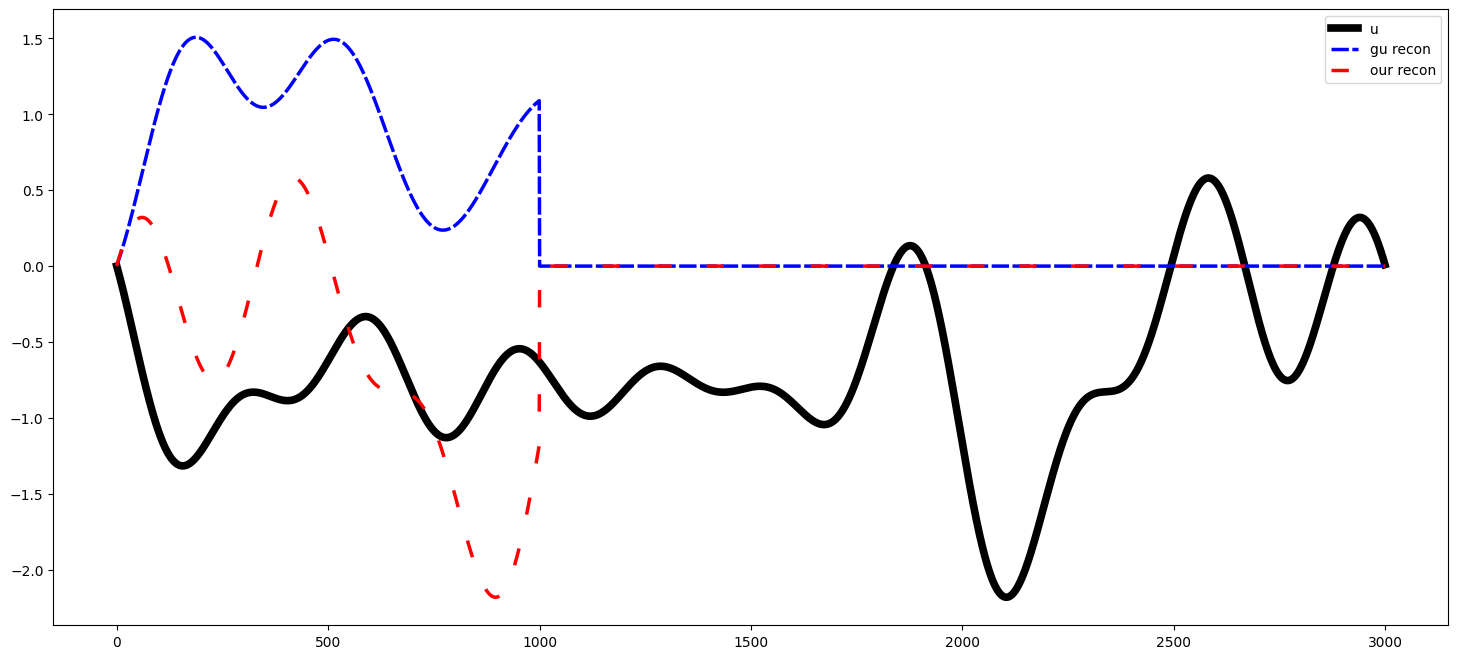

In [48]:
gu_y = gu_y_dict["legtlti"]
y = y_dict["legtlti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### LMU

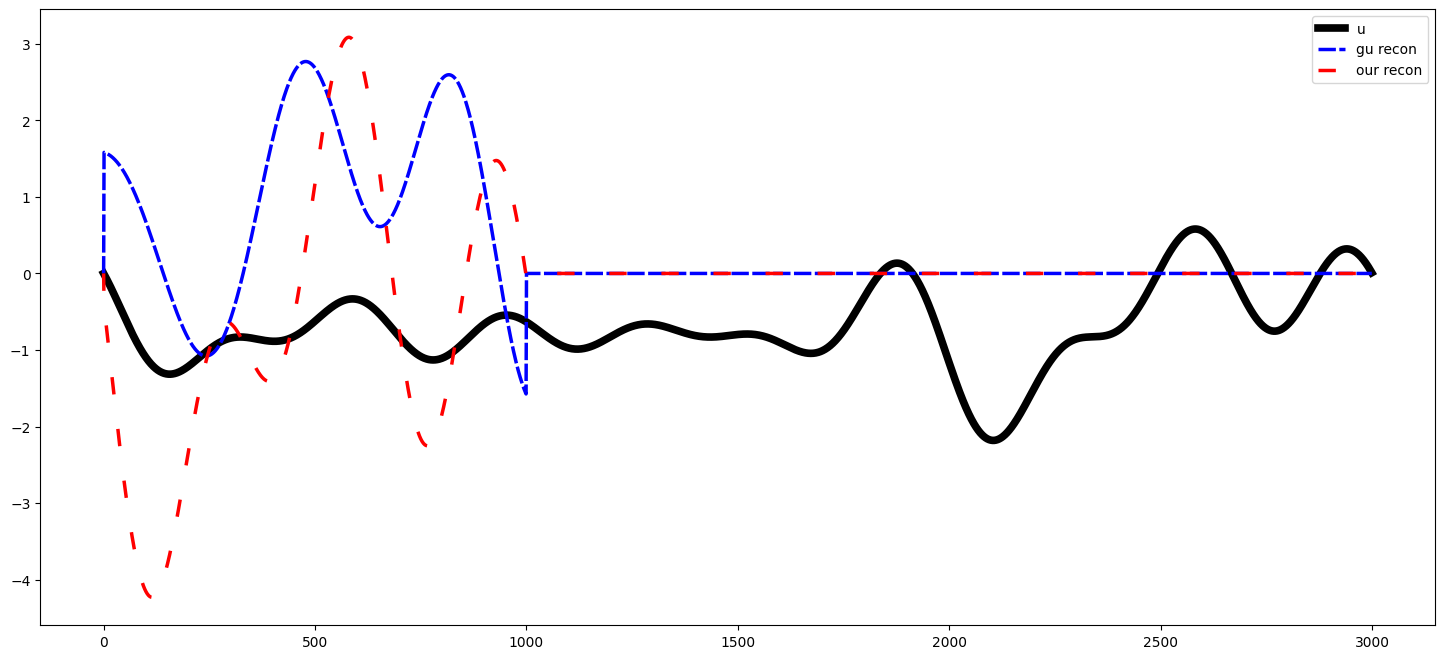

In [49]:
gu_y = gu_y_dict["lmulti"]
y = y_dict["lmulti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### LagT

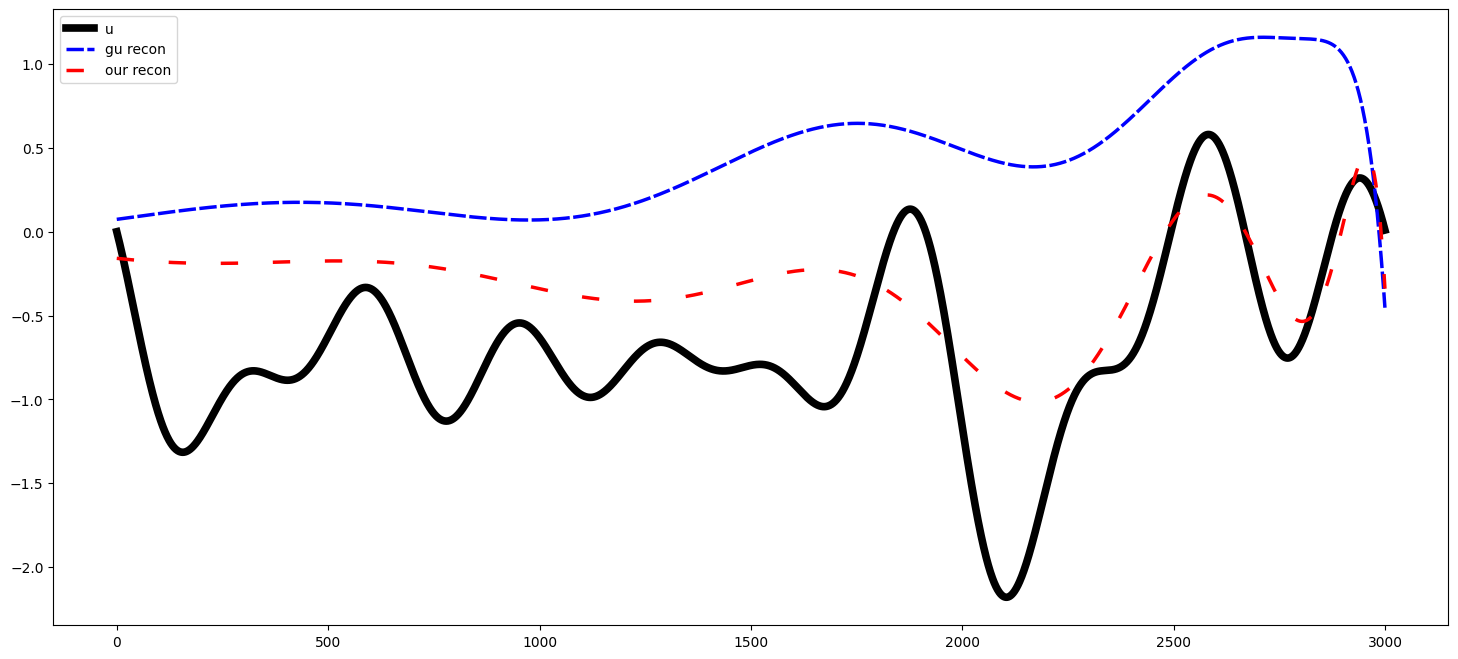

In [50]:
gu_y = gu_y_dict["lagtlti"]
y = y_dict["lagtlti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### FRU

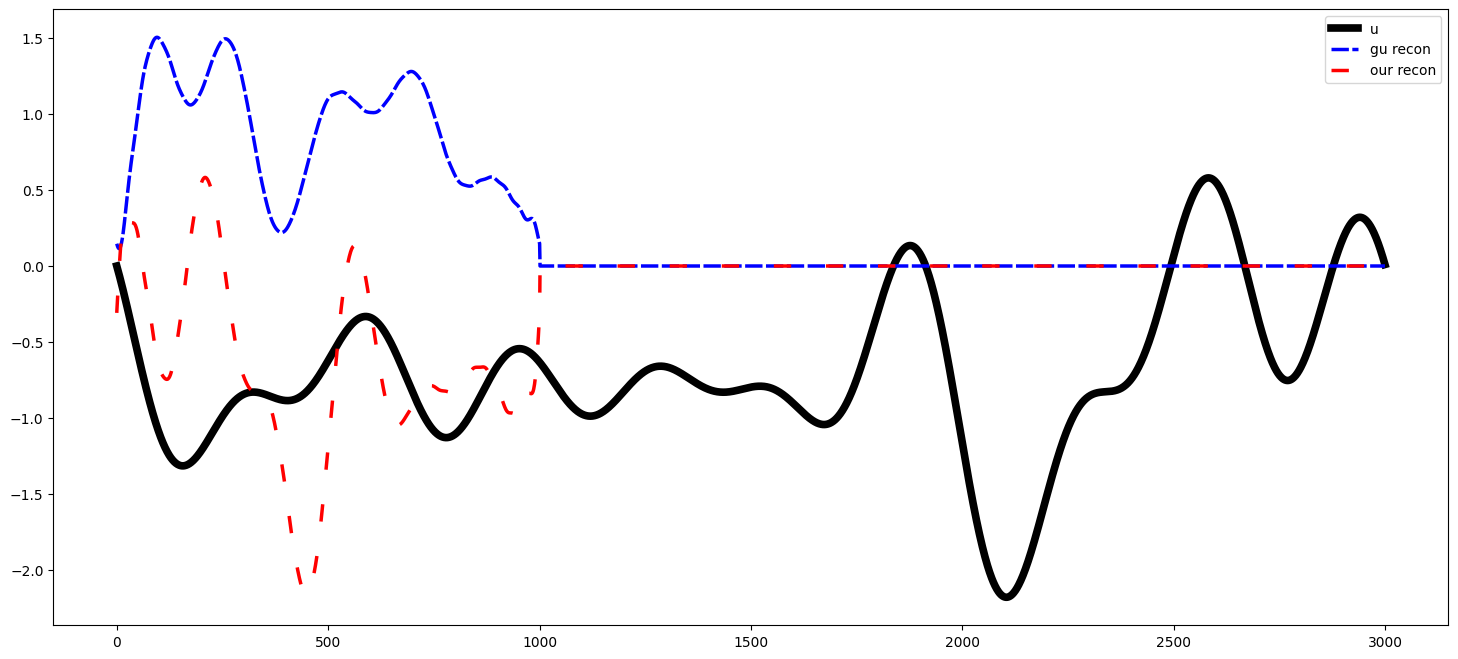

In [51]:
gu_y = gu_y_dict["frulti"]
y = y_dict["frulti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### FouT

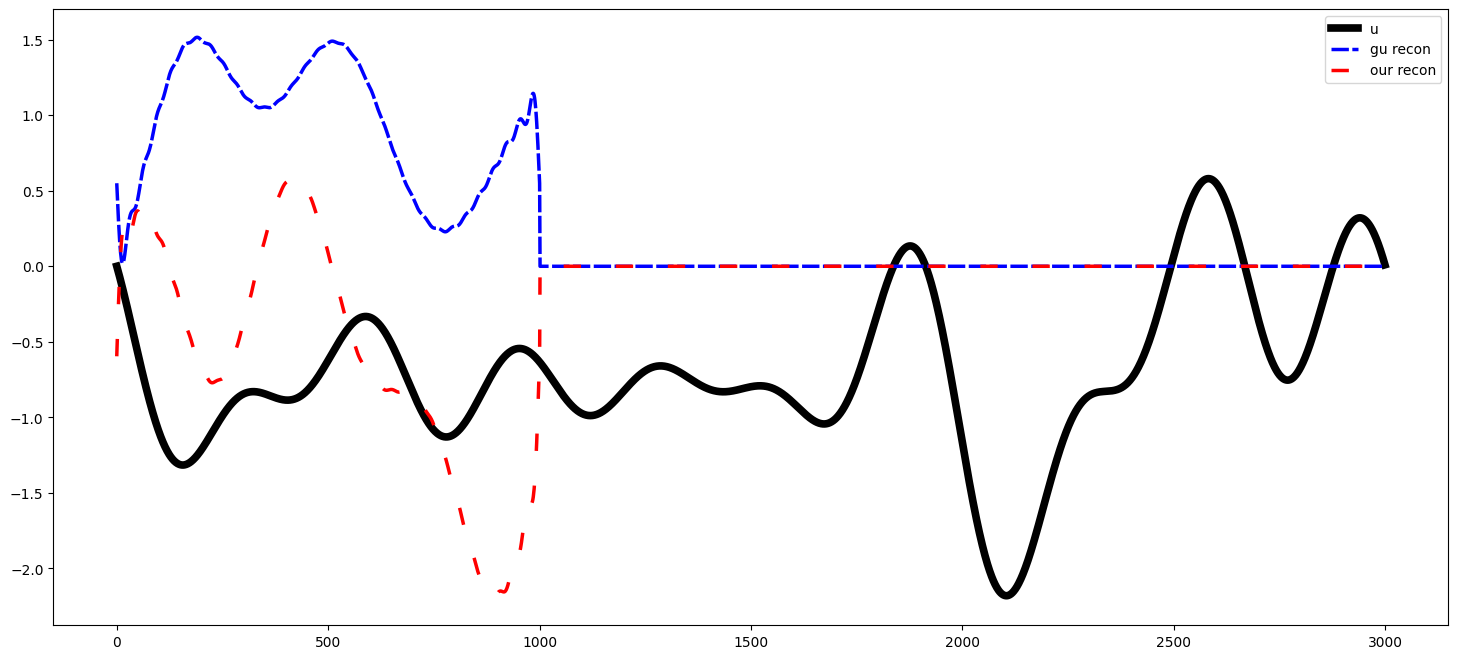

In [52]:
gu_y = gu_y_dict["foutlti"]
y = y_dict["foutlti"]
plot_comparison(u=u, gu_y=gu_y, y=y)

#### FouD

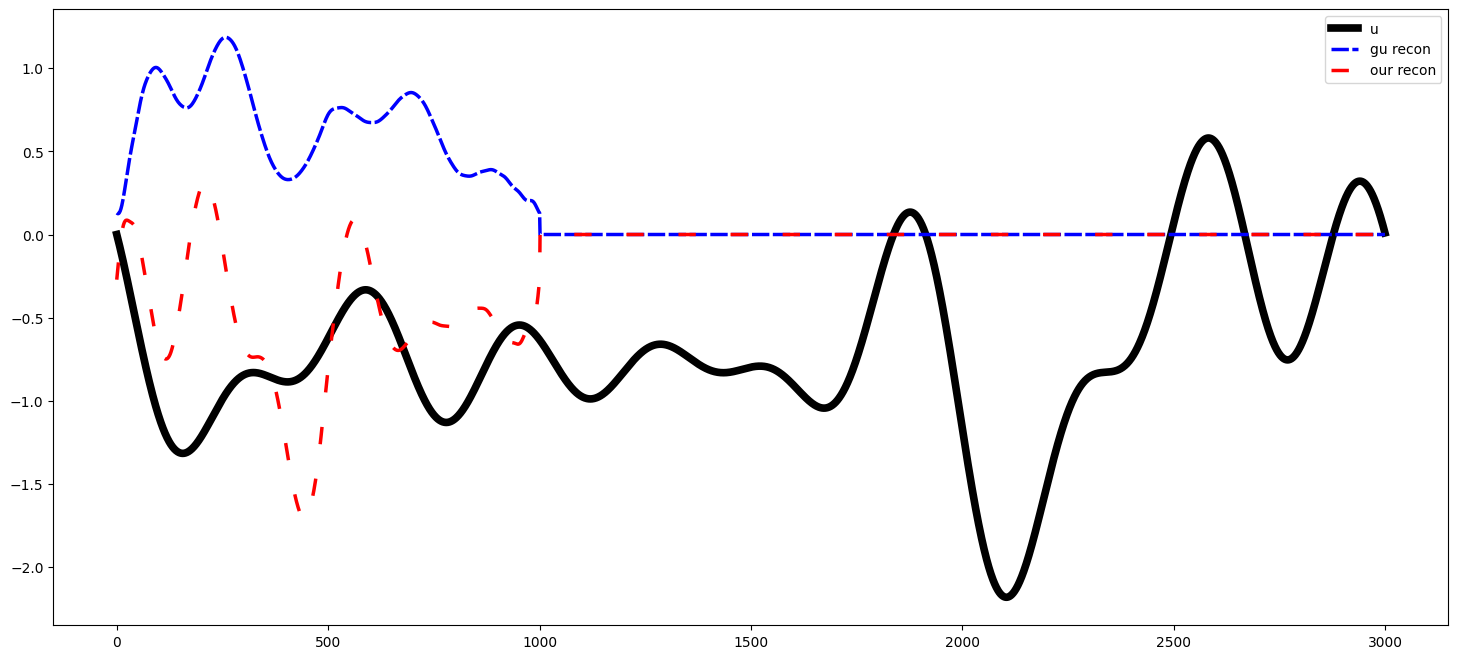

In [53]:
gu_y = gu_y_dict["foudlti"]
y = y_dict["foudlti"]
plot_comparison(u=u, gu_y=gu_y, y=y)